In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_corrected.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Salinas_gt.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/PaviaU_gt.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/KSC.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Salinas_corrected.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_gt.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/PaviaU.mat
/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/KSC_gt.mat


In [2]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [3]:
!pip install ripser persim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 11.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.2 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=e23811abe00aa945b8c6e3de924b227cd8f77d8085fe4bd155c80a2fcf25b755
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [4]:
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import scipy.ndimage as nd
import numpy as np
from ripser import ripser
from scipy.stats import entropy
from tensorflow.keras import layers


E0000 00:00:1754109037.638095      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754109037.696383      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Load Indian Pines HSI cube and labels
data = sio.loadmat("/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_corrected.mat")
cube = data['indian_pines_corrected']  # Shape: (145, 145, 200)

gt_data = sio.loadmat("/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_gt.mat")
gt = gt_data['indian_pines_gt']        # Shape: (145, 145)

# Normalize spectral bands per-pixel
H, W, B = cube.shape
cube_2d = cube.reshape(-1, B)
scaler = StandardScaler()
cube_norm = scaler.fit_transform(cube_2d)
cube_norm = cube_norm.reshape(H, W, B)

print("Normalized cube shape:", cube_norm.shape) #Normalized cube shape: (145, 145, 200)
print("Label shape:", gt.shape) #Label shape: (145, 145)

Normalized cube shape: (145, 145, 200)
Label shape: (145, 145)


In [6]:
#Patch Extraction for Training
def extract_patches_tf(cube, labels, patch_size=13):
    pad = patch_size // 2
    H, W, B = cube.shape

    padded_cube = np.pad(cube, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

    X_patches = []
    y_labels = []

    for i in range(H):
        for j in range(W):
            if labels[i, j] == 0:
                continue
            patch = padded_cube[i:i+patch_size, j:j+patch_size, :]
            X_patches.append(patch)
            y_labels.append(labels[i, j] - 1)  # classes from 0

    return np.array(X_patches), np.array(y_labels)

# Extract labeled patches
X, y = extract_patches_tf(cube_norm, gt, patch_size=13)
num_classes = np.max(y) + 1
print("X shape:", X.shape)  # (N, 13, 13, B) X shape: (10249, 13, 13, 200)
print("y shape:", y.shape)  # (N,) y shape: (10249,)
print("Num classes:", num_classes) #Num classes: 16

X shape: (10249, 13, 13, 200)
y shape: (10249,)
Num classes: 16


In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Convert labels to one-hot
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("Train:", X_train.shape) #Train: (6149, 13, 13, 200)
print("Val:", X_val.shape) #Val: (2050, 13, 13, 200)
print("Test:", X_test.shape) #Test: (2050, 13, 13, 200)

Train: (6149, 13, 13, 200)
Val: (2050, 13, 13, 200)
Test: (2050, 13, 13, 200)


# Morphological Band Saliency Attention 

In [8]:
# Morphological operation: returns 4-band saliency scores
def morph_saliency_ops(patch):
    # patch: shape (13, 13, 200) — numpy array
    saliency = []
    for i in range(patch.shape[-1]):
        band = patch[:, :, i]
        d = nd.grey_dilation(band, size=(3, 3))
        e = nd.grey_erosion(band, size=(3, 3))
        o = nd.grey_opening(band, size=(3, 3))
        c = nd.grey_closing(band, size=(3, 3))

        score = (
            np.mean((d - band) ** 2) +
            np.mean((e - band) ** 2) +
            np.mean((o - band) ** 2) +
            np.mean((c - band) ** 2)
        )
        saliency.append(score)
    return np.array(saliency, dtype=np.float32)  # shape: (200,)

## Vectorize Band Ranking + Select Top-K Bands

In [9]:
def select_topk_bands(X_full, k=30, sample_size=1000):
    print("Sampling for MBSA...")
    if X_full.shape[0] > sample_size:
        idx = np.random.choice(X_full.shape[0], sample_size, replace=False)
        X_sample = X_full[idx]
    else:
        X_sample = X_full

    band_saliency = np.zeros(X_sample.shape[-1])
    for i in range(X_sample.shape[0]):
        s = morph_saliency_ops(X_sample[i])
        band_saliency += s
    band_saliency /= X_sample.shape[0]

    topk_indices = np.argsort(band_saliency)[-k:]
    print("Top-k bands:", topk_indices)
    return topk_indices

In [10]:
top_k = 30
topk_indices = select_topk_bands(X_train, k=top_k, sample_size=1000)

Sampling for MBSA...
Top-k bands: [104  91  81  74  79  94   2  92  60 198  83  75  96  95  82 143 144   1
  85  84  93 102  86  88  89  90 103  87 199   0]


In [11]:
X_train_sel = X_train[..., topk_indices]
X_val_sel   = X_val[..., topk_indices]
X_test_sel  = X_test[..., topk_indices]

# Topological Feature Extraction (with ripser)

In [12]:
def compute_persistence_entropy(diagram, epsilon=1e-8):
    lifetimes = diagram[:, 1] - diagram[:, 0]
    lifetimes = lifetimes[lifetimes > 0]

    if len(lifetimes) == 0 or np.sum(lifetimes) < epsilon:
        return 0.0

    probs = lifetimes / (np.sum(lifetimes) + epsilon)
    return entropy(probs)

# Extract Topological Feature from One Spectrum

In [13]:
def extract_topo_feature(spectrum_1d):
    """
    spectrum_1d: (30,) vector → reshaped to (30, 1)
    Returns: scalar entropy value
    """
    point_cloud = spectrum_1d.reshape(-1, 1)
    dgms = ripser(point_cloud, maxdim=0)['dgms'][0]  # 0D homology
    pe = compute_persistence_entropy(dgms)
    return pe

In [14]:
def generate_topo_features(X_patches):
    topo = []
    for i in range(len(X_patches)):
        spectrum = np.mean(X_patches[i], axis=(0, 1))  # (30,)
        topo_feat = extract_topo_feature(spectrum)
        topo.append(topo_feat)
    return np.array(topo).reshape(-1, 1)

topo_train = generate_topo_features(X_train_sel)
topo_val   = generate_topo_features(X_val_sel)
topo_test  = generate_topo_features(X_test_sel)

print("Topological feature shapes:", topo_train.shape, topo_val.shape, topo_test.shape)

Topological feature shapes: (6149, 1) (2050, 1) (2050, 1)


X_train_sel: (6149, 13, 13, 30) → input to CNN

topo_train: (6149, 1) → topological entropy vector

y_train_cat: (6149, 16) → one-hot labels

#  RGConv Block (Spatial Extractor)

In [15]:
from tensorflow.keras import layers, models
def RGConvBlock(input_tensor, filters):
    x1 = layers.Conv2D(filters, 3, padding='same', activation='relu')(input_tensor)
    x2 = layers.Conv2D(filters, 3, padding='same', activation='relu')(input_tensor)
    gated = layers.Multiply()([x1, x2])
    
    # Enhanced feature propagation
    x3 = layers.Conv2D(filters, 3, padding='same', activation='relu')(gated)
    x4 = layers.Conv2D(filters, 3, padding='same', activation='relu')(gated)
    output = layers.Multiply()([x3, x4])
    return output

# UNet++ Decoder Block (Spectral Decoder)

In [16]:
from tensorflow.keras import layers

def UNetPlusPlusDecoder(input_tensor, filters=64):
    # Initial Conv block
    conv1 = layers.Conv2D(filters, 3, padding='same', activation='relu')(input_tensor)
    conv1 = layers.Conv2D(filters, 3, padding='same', activation='relu')(conv1)
    
    # Downsample
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Bottleneck
    conv2 = layers.Conv2D(filters * 2, 3, padding='same', activation='relu')(pool1)
    conv2 = layers.Conv2D(filters * 2, 3, padding='same', activation='relu')(conv2)
    
    # Up + concat + conv
    up1 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(conv2)
    up1 = layers.Resizing(conv1.shape[1], conv1.shape[2])(up1)  # Ensure exact size match
    merge = layers.Concatenate()([up1, conv1])
    
    conv3 = layers.Conv2D(filters, 3, padding='same', activation='relu')(merge)
    conv3 = layers.Conv2D(filters, 3, padding='same', activation='relu')(conv3)
    
    # Gated refinement
    gate_1 = layers.Conv2D(filters, 3, padding='same', activation='relu')(input_tensor)
    gate_2 = layers.Conv2D(filters, 3, padding='same', activation='sigmoid')(input_tensor)
    gated = layers.Multiply()([gate_1, gate_2])  # Feature-wise attention
    # Add spectral residual
    output = layers.Add()([conv3, gated])
    return output

In [17]:
def TopoAttentionFusion(spectral_feat, topo_feat, filters=64):
    """
    Fuse spectral feature maps with topological descriptors using learned attention.
    Args:
        spectral_feat: [B, H, W, C]
        topo_feat:     [B, 1] or [B, D]
        filters:       int, number of output filters (must match spectral_feat channels)
    Returns:
        Fused feature map: [B, H, W, C]
    """
    # Project topo_feat to match spectral channels
    topo_dense = layers.Dense(filters, activation='relu')(topo_feat)  # [B, filters]
    topo_reshape = layers.Reshape((1, 1, filters))(topo_dense)         # [B, 1, 1, C]
    
    # Learnable scaling of spectral features
    scaled_spectral = layers.Multiply()([spectral_feat, topo_reshape])  # Element-wise scale
    
    # Optional recalibration via Conv2D (acts like SE block)
    recal = layers.Conv2D(filters, kernel_size=1, padding='same', activation='relu')(scaled_spectral)
    
    return recal

# Topological Attention Fusion Layer

# Final Model Assembly: TopoMorph-RGNet v2

In [18]:
def build_topomorph_model(input_shape, topo_dim, num_classes):
    # Inputs
    input_img = layers.Input(shape=input_shape)      # (13,13,30)
    input_topo = layers.Input(shape=(topo_dim,))     # (1)

    # Spatial stream
    x_spatial = RGConvBlock(input_img, filters=64)

    # Spectral decoder
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)

    # Topological attention fusion
    x_fused = TopoAttentionFusion(x_spectral, input_topo, filters=64)

    # Combine spatial & spectral-topo
    combined = layers.Add()([x_spatial, x_spectral])
    pooled = layers.GlobalAveragePooling2D()(combined)

    # Final classifier
    output = layers.Dense(num_classes, activation='softmax')(pooled)

    # Model
    model = models.Model(inputs=[input_img, input_topo], outputs=output)
    return model

In [19]:
model = build_topomorph_model(input_shape=(13,13,30), topo_dim=1, num_classes=16)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

I0000 00:00:1754109094.843773      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754109094.844466      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Inputs:

HSI patch → (13, 13, 30)

Topological entropy → (1,)

Two streams:

RGConv spatial path

UNet++ spectral decoder + topological fusion

Final classifier → 16 classes

#### Input 1 → HSI Patch → RGConv + UNet++

#### Input 2 → Topological Entropy → Attention gating

#### Fused spatial & spectral streams → final dense classifier

In [20]:
print(type(X_train_sel), X_train_sel.shape)
print(type(topo_train), topo_train.shape)
print(type(y_train_cat), y_train_cat.shape)
'''<class 'numpy.ndarray'> (6149, 13, 13, 30)
<class 'numpy.ndarray'> (6149, 1)
<class 'numpy.ndarray'> (6149, 16)'''

<class 'numpy.ndarray'> (6149, 13, 13, 30)
<class 'numpy.ndarray'> (6149, 1)
<class 'numpy.ndarray'> (6149, 16)


"<class 'numpy.ndarray'> (6149, 13, 13, 30)\n<class 'numpy.ndarray'> (6149, 1)\n<class 'numpy.ndarray'> (6149, 16)"

In [21]:
# Train dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat))
train_dataset = train_dataset.shuffle(buffer_size=2048).batch(64)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat))
val_dataset = val_dataset.batch(64)

# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat))
test_dataset = test_dataset.batch(64)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True),
    ModelCheckpoint("best_topomorph.keras", monitor='val_accuracy', save_best_only=True)
]

In [23]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1754109102.337627     109 service.cc:148] XLA service 0x7b59d4028b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754109102.338144     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754109102.338180     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754109102.927330     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


11/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2863 - loss: 2.3215

I0000 00:00:1754109106.676033     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.5681 - loss: 1.3468 - val_accuracy: 0.8907 - val_loss: 0.3320
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8966 - loss: 0.3181 - val_accuracy: 0.9278 - val_loss: 0.2202
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9187 - loss: 0.2536 - val_accuracy: 0.9546 - val_loss: 0.1863
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9563 - loss: 0.1411 - val_accuracy: 0.9844 - val_loss: 0.0555
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9721 - loss: 0.0761 - val_accuracy: 0.9756 - val_loss: 0.0624
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9701 - loss: 0.0883 - val_accuracy: 0.9737 - val_loss: 0.0813
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9827 - loss: 0.0510 - val_accuracy: 0.9741 - val_loss: 0.0787
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9574 - loss: 0.1575 - val_accuracy: 0.9863 - val_loss: 0

In [24]:
model.save("best_topomorph.keras")

In [25]:
from tensorflow.keras.models import load_model
proposed_model = load_model("best_topomorph.keras")

In [26]:
res = model.evaluate(test_dataset)
print("Test Loss:", res[0])
print("Test Accuracy:", res[1])
y_true = np.argmax(y_test_cat, axis=1)

# Predict probabilities
y_pred_probs = proposed_model.predict(test_dataset)
y_pred_proposed = np.argmax(y_pred_probs, axis=1)
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix, f1_score

oa = accuracy_score(y_true, y_pred_proposed)
kappa = cohen_kappa_score(y_true, y_pred_proposed)
f1 = f1_score(y_true, y_pred_proposed, average='macro')
conf_mat = confusion_matrix(y_true, y_pred_proposed)

# AA (Average Accuracy per class)
report = classification_report(y_true, y_pred_proposed, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(1, 16)
             if str(i) in report])  # Ignore background class 0

print("Overall Accuracy (OA):", oa)
print("Average Accuracy (AA):", aa)
print("Kappa Coefficient:", kappa)
print("F1 Score (Macro):", f1)
print("Confusion Matrix:\n", conf_mat)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0033
Test Loss: 0.0025762643199414015
Test Accuracy: 0.9990243911743164
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Overall Accuracy (OA): 0.9990243902439024
Average Accuracy (AA): 0.9972222222222222
Kappa Coefficient: 0.9988877983887725
F1 Score (Macro): 0.9981450026819239
Confusion Matrix:
 [[  9   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 285   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  46   0   0   0   0   0   0   0   2   0   0   0   0]
 [  0   0   0   0  97   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 146   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   6   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  95   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 1

###  PCA variant:

In [29]:
from sklearn.decomposition import PCA

def apply_pca(X_data, num_components=30):
    N, H, W, B = X_data.shape
    X_flat = X_data.reshape(-1, B)
    pca = PCA(n_components=num_components)
    X_pca = pca.fit_transform(X_flat)
    X_pca_reshaped = X_pca.reshape(N, H, W, num_components)
    return X_pca_reshaped

X_train_pca = apply_pca(X_train)
X_val_pca = apply_pca(X_val)
X_test_pca = apply_pca(X_test)

### All Bands (no band selection):

In [34]:
X_train_sel = X_train
X_val_sel = X_val
X_test_sel = X_test

🔁 Now run the training and evaluation loop 3 times, one for each variant. Below is the full code block you can use — only change X_train_sel, X_val_sel, X_test_sel each time.

| Run           | Code Before                                |
| ------------- | ------------------------------------------ |
| **MBSA**      | `X_train_sel = X_train[..., topk_indices]` |
| **PCA**       | `X_train_sel = X_train_pca`                |
| **All Bands** | `X_train_sel = X_train`                    |


In [42]:
# Topological features (reuse if not recalculating)
topo_train = generate_topo_features(X_train_sel)
topo_val = generate_topo_features(X_val_sel)
topo_test = generate_topo_features(X_test_sel)

# Model
model = build_topomorph_model(input_shape=X_train_sel.shape[1:], topo_dim=1, num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a1_variant_model.keras", monitor='val_accuracy', save_best_only=True)
]

# Train
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=callbacks)

# Evaluate
model = load_model("a1_variant_model.keras")
res = model.evaluate(test_dataset)
print("Test Loss:", res[0])
print("Test Accuracy:", res[1])

# Get predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
report = classification_report(y_true, y_pred, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(1, 16) if str(i) in report])

print(f"OA: {oa:.4f}, AA: {aa:.4f}, Kappa: {kappa:.4f}, Macro F1: {f1:.4f}")

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.5147 - loss: 2.0190 - val_accuracy: 0.7551 - val_loss: 0.7243
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8455 - loss: 0.4565 - val_accuracy: 0.8385 - val_loss: 0.4304
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8606 - loss: 0.5461 - val_accuracy: 0.9137 - val_loss: 0.2416
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9383 - loss: 0.1896 - val_accuracy: 0.9293 - val_loss: 0.2149
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9550 - loss: 0.1336 - val_accuracy: 0.9707 - val_loss: 0.0880
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9630 - loss: 0.1188 - val_accuracy: 0.9751 - val_loss: 0.0884
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9638 - loss: 0.1323 - val_accuracy: 0.9639 - val_loss: 0.1016
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9712 - loss: 0.0841 - val_accuracy: 0

## All bands
Test Loss: 0.005679208319634199

Test Accuracy: 0.9985365867614746

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
OA: 0.9985,

AA: 0.9966,

Kappa: 0.9983,

Macro F1: 0.9980

In [47]:
# 1. Assign PCA data to _sel variables
X_train_sel = X_train_pca
X_val_sel = X_val_pca
X_test_sel = X_test_pca

# 2. Generate topological features from PCA-selected bands
topo_train = generate_topo_features(X_train_sel)
topo_val   = generate_topo_features(X_val_sel)
topo_test  = generate_topo_features(X_test_sel)

# 3. Build and compile model
model = build_topomorph_model(input_shape=X_train_sel.shape[1:], topo_dim=1, num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Create datasets using _sel variables
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a1_variant_model.keras", monitor='val_accuracy', save_best_only=True)
]

# Train
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=callbacks)

# Evaluate
model = load_model("a1_variant_model.keras")
res = model.evaluate(test_dataset)
print("Test Loss:", res[0])
print("Test Accuracy:", res[1])

# Get predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
report = classification_report(y_true, y_pred, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(1, 16) if str(i) in report])

print(f"OA: {oa:.4f}, AA: {aa:.4f}, Kappa: {kappa:.4f}, Macro F1: {f1:.4f}")


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6200 - loss: 1.6878 - val_accuracy: 0.9146 - val_loss: 0.2697
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9535 - loss: 0.1484 - val_accuracy: 0.9395 - val_loss: 0.2138
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9793 - loss: 0.0622 - val_accuracy: 0.9327 - val_loss: 0.2319
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9898 - loss: 0.0401 - val_accuracy: 0.9454 - val_loss: 0.2047
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9876 - loss: 0.0402 - val_accuracy: 0.9439 - val_loss: 0.2317
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9717 - loss: 0.0946 - val_accuracy: 0.9717 - val_loss: 0.1035
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9866 - loss: 0.0582 - val_accuracy: 0.9483 - val_loss: 0.2082
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9967 - loss: 0.0168 - val_accuracy: 0

#### pca

Test Loss: 0.029735520482063293

Test Accuracy: 0.9878048896789551

OA: 0.9878, 

AA: 0.9724, 

Kappa: 0.9861, 

Macro F1: 0.9822

In [45]:
X_train_sel = X_train[..., topk_indices]
X_val_sel   = X_val[..., topk_indices]
X_test_sel  = X_test[..., topk_indices]

In [46]:
# Topological features for mbsa
topo_train = generate_topo_features(X_train_sel)
topo_val = generate_topo_features(X_val_sel)
topo_test = generate_topo_features(X_test_sel)

# Model
model = build_topomorph_model(input_shape=X_train_sel.shape[1:], topo_dim=1, num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a1_variant_model.keras", monitor='val_accuracy', save_best_only=True)
]

# Train
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=callbacks)

# Evaluate
model = load_model("a1_variant_model.keras")
res = model.evaluate(test_dataset)
print("Test Loss:", res[0])
print("Test Accuracy:", res[1])

# Get predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
report = classification_report(y_true, y_pred, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(1, 16) if str(i) in report])

print(f"OA: {oa:.4f}, AA: {aa:.4f}, Kappa: {kappa:.4f}, Macro F1: {f1:.4f}")

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.5533 - loss: 1.3814 - val_accuracy: 0.8922 - val_loss: 0.3336
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9127 - loss: 0.2595 - val_accuracy: 0.9624 - val_loss: 0.1321
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9527 - loss: 0.1529 - val_accuracy: 0.9829 - val_loss: 0.0675
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9756 - loss: 0.0681 - val_accuracy: 0.9776 - val_loss: 0.0702
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9680 - loss: 0.0926 - val_accuracy: 0.9439 - val_loss: 0.4198
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9610 - loss: 0.1846 - val_accuracy: 0.9785 - val_loss: 0.0691
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9856 - loss: 0.0377 - val_accuracy: 0.9902 - val_loss: 0.0299
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9904 - loss: 0.0325 - val_accuracy: 0

#### mbsa
Test Loss: 0.003621302777901292

Test Accuracy: 0.9995121955871582

OA: 0.9995,

AA: 0.9965, 

Kappa: 0.9994,

Macro F1: 0.9980

## ✅ A2: Persistent Homology Gate On vs Off

### To disable topo gate:

In [35]:
def build_topomorph_model_no_topo(input_shape, num_classes):
    input_img = layers.Input(shape=input_shape)
    x_spatial = RGConvBlock(input_img, filters=64)
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)
    combined = layers.Add()([x_spatial, x_spectral])
    pooled = layers.GlobalAveragePooling2D()(combined)
    output = layers.Dense(num_classes, activation='softmax')(pooled)
    model = models.Model(inputs=input_img, outputs=output)
    return model


In [55]:
# If using MBSA
X_train_sel = X_train[..., topk_indices]
X_val_sel   = X_val[..., topk_indices]
X_test_sel  = X_test[..., topk_indices]

In [49]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sel, y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val_sel, y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices((X_test_sel, y_test_cat)).batch(64)


### Build and train the "no-topo" model:

In [50]:
model = build_topomorph_model_no_topo(input_shape=X_train_sel.shape[1:], num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a2_no_topo_model.keras", monitor='val_accuracy', save_best_only=True)
]
history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=callbacks)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.5888 - loss: 1.2917 - val_accuracy: 0.8444 - val_loss: 0.4396
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9120 - loss: 0.2867 - val_accuracy: 0.9541 - val_loss: 0.1367
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9568 - loss: 0.1347 - val_accuracy: 0.8849 - val_loss: 0.3350
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9554 - loss: 0.1327 - val_accuracy: 0.9585 - val_loss: 0.1148
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9686 - loss: 0.0838 - val_accuracy: 0.9756 - val_loss: 0.0997
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9780 - loss: 0.0850 - val_accuracy: 0.9917 - val_loss: 0.0370
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9912 - loss: 0.0233 - val_accuracy: 0.9873 - val_loss: 0.0373
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9918 - loss: 0.0285 - val_accuracy: 0

In [51]:
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, f1_score

model = load_model("a2_no_topo_model.keras")
res = model.evaluate(test_dataset)
print("Test Loss:", res[0])
print("Test Accuracy:", res[1])

# Predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
report = classification_report(y_true, y_pred, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(1, 16) if str(i) in report])

print(f"A2 (No Topo) → OA: {oa:.4f}, AA: {aa:.4f}, Kappa: {kappa:.4f}, F1: {f1:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9994 - loss: 0.0051
Test Loss: 0.004483590833842754
Test Accuracy: 0.9990243911743164
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
A2 (No Topo) → OA: 0.9990, AA: 0.9930, Kappa: 0.9989, F1: 0.9960


accuracy: 0.9994 - loss: 0.0051

Test Loss: 0.004483590833842754

Test Accuracy: 0.9990243911743164

A2 (No Topo) → OA: 0.9990,

AA: 0.9930, 

Kappa: 0.9989, 

F1: 0.9960

Cross-Gating (current) – implemented via TopoAttentionFusion(...)



## ✅ A3: Fusion Method – Cross-Gating vs Late Fusion vs Additive

### Late Fusion (no interaction, average outputs):

In [37]:
def build_latefusion_model(input_shape, topo_dim, num_classes):
    input_img = layers.Input(shape=input_shape)
    input_topo = layers.Input(shape=(topo_dim,))
    x_spatial = RGConvBlock(input_img, filters=64)
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)

    pooled_img = layers.GlobalAveragePooling2D()(x_spatial)
    pooled_spec = layers.GlobalAveragePooling2D()(x_spectral)
    topo_dense = layers.Dense(64, activation='relu')(input_topo)

    combined = layers.Average()([pooled_img, pooled_spec, topo_dense])
    output = layers.Dense(num_classes, activation='softmax')(combined)
    return models.Model(inputs=[input_img, input_topo], outputs=output)


In [52]:
model = build_latefusion_model(input_shape=X_train_sel.shape[1:], topo_dim=topo_train.shape[1], num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a3_latefusion_model.keras", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=callbacks)
model = load_model("a3_latefusion_model.keras")
res = model.evaluate(test_dataset)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.0095 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0093 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0107 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0102 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0083 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0092 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0089 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0117 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 9/100
97/97 ━━━━━

In [54]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, jaccard_score

# Step 1: Get predictions and true labels
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_dataset], axis=0)

# Step 2: Compute OA (Overall Accuracy)
oa = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy (OA): {oa:.4f}")

# Step 3: Compute AA (Average Accuracy)
conf_mat = confusion_matrix(y_true, y_pred)
class_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)
aa = np.mean(class_acc)
print(f"Average Accuracy (AA): {aa:.4f}")

# Step 4: Compute Precision, Recall, F1 (Macro avg)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")

# Step 5: Compute mIoU (mean Intersection over Union)
miou = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
print(f"Mean IoU (mIoU):   {miou:.4f}")

# Step 6: Full classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4, zero_division=0))

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Overall Accuracy (OA): 0.0044
Average Accuracy (AA): 0.0625
Precision (macro): 0.0003
Recall (macro):    0.0625
F1-score (macro):  0.0005
Mean IoU (mIoU):   0.0003

Classification Report:
              precision    recall  f1-score   support

           0     0.0044    1.0000    0.0087         9
           1     0.0000    0.0000    0.0000       285
           2     0.0000    0.0000    0.0000       166
           3     0.0000    0.0000    0.0000        48
           4     0.0000    0.0000    0.0000        97
           5     0.0000    0.0000    0.0000       146
           6     0.0000    0.0000    0.0000         6
           7     0.0000    0.0000    0.0000        95
           8     0.0000    0.0000    0.0000         4
           9     0.0000    0.0000    0.0000       195
          10     0.0000    0.0000    0.0000       491
          11     0.0000    0.0000    0.0000       118
          12     0.0000    0.0000    0.0000        41
          13   

### ✅ 2. Cross-Gating Fusion (your existing TopoMorph RGNet)


In [59]:
def build_topomorph_model_crossgate(input_shape, topo_dim, num_classes):
    input_img = layers.Input(shape=input_shape)      # e.g., (13, 13, 30)
    input_topo = layers.Input(shape=(topo_dim,))     # e.g., (1,)

    # Branch 1: Spatial features via RGConv
    x_spatial = RGConvBlock(input_img, filters=64)

    # Branch 2: Spectral features via UNet++
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)

    # Apply Cross-Gating Fusion (TopoAttention) on Spectral + Topo
    x_fused = TopoAttentionFusion(x_spectral, input_topo, filters=64)

    # Combine fused spectral + spatial features
    combined = layers.Add()([x_spatial, x_fused])  # ✅ use fused spectral!

    # Final layers
    pooled = layers.GlobalAveragePooling2D()(combined)
    output = layers.Dense(num_classes, activation='softmax')(pooled)

    model = models.Model(inputs=[input_img, input_topo], outputs=output)
    return model

In [60]:
model = build_topomorph_model_crossgate(input_shape=X_train_sel.shape[1:], topo_dim=topo_train.shape[1], num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_crossgate.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, f1_score, accuracy_score, jaccard_score
import numpy as np

# Predict
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
oa = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
aa = np.mean(conf_matrix.diagonal() / conf_matrix.sum(axis=1))
kappa = cohen_kappa_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average=None)
miou = jaccard_score(y_true, y_pred, average='macro')

# Dict of results
results_crossgate = {
    "OA": oa,
    "AA": aa,
    "Kappa": kappa,
    "F1_per_class": f1,
    "mIoU": miou
}

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.0097 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0104 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0094 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0098 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0121 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0096 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0100 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0092 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 9/100
97/97 ━━━━━

In [61]:
results_crossgate

{'OA': 0.004390243902439025,
 'AA': 0.0625,
 'Kappa': 0.0,
 'F1_per_class': array([0.00874211, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 'mIoU': 0.00027439024390243905}

### Additive Fusion (your original fusion):

In [53]:
def build_addfusion_model(input_shape, topo_dim, num_classes):
    input_img = layers.Input(shape=input_shape)
    input_topo = layers.Input(shape=(topo_dim,))

    x_spatial = RGConvBlock(input_img, filters=64)
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)

    pooled_img = layers.GlobalAveragePooling2D()(x_spatial)
    pooled_spec = layers.GlobalAveragePooling2D()(x_spectral)
    topo_dense = layers.Dense(64, activation='relu')(input_topo)

    # Simple element-wise add
    added = layers.Add()([pooled_img, pooled_spec, topo_dense])
    output = layers.Dense(num_classes, activation='softmax')(added)

    model = models.Model(inputs=[input_img, input_topo], outputs=output)
    return model


In [56]:
model = build_addfusion_model(X_train_sel.shape[1:], topo_train.shape[1], num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset   = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset  = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("a3_addfusion_model.keras", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=callbacks)
model = load_model("a3_addfusion_model.keras")
res = model.evaluate(test_dataset)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.0097 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0111 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0101 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0087 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0093 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0090 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0103 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0093 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 9/100
97/97 ━━━━━

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import numpy as np

# Predict on test data
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)
print("Overall Accuracy (OA)%:", oa*100)

# Average Accuracy (AA)
conf_mat = confusion_matrix(y_true, y_pred)
class_accuracies = conf_mat.diagonal() / conf_mat.sum(axis=1)
aa = np.mean(class_accuracies)
print("Average Accuracy (AA)%:", aa*100)

# F1-Score (per class & average)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_per_class = f1_score(y_true, y_pred, average=None)
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Per Class):", f1_per_class)

# Precision & Recall
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print("Precision (Macro):", precision)
print("Recall (Macro):", recall)

# mIoU (mean Intersection over Union)
miou = jaccard_score(y_true, y_pred, average='macro')
print("Mean IoU (mIoU):", miou)

# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred))


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Overall Accuracy (OA)%: 0.4390243902439025
Average Accuracy (AA)%: 6.25
F1 Score (Macro): 0.0005463817387081108
F1 Score (Per Class): [0.00874211 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Precision (Macro): 0.00027439024390243905
Recall (Macro): 0.0625
Mean IoU (mIoU): 0.00027439024390243905

Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.01         9
           1       0.00      0.00      0.00       285
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        97
           5       0.00      0.00      0.00       146
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        95
           8       0.00      0.00      0.00   

## ✅ A4: RGC Depth and Kernel Size

In [39]:
# Variant: deeper RGConvBlock with larger kernels
def RGConvBlock_deep(input_tensor, filters):
    x = input_tensor
    for _ in range(4):  # more layers
        x1 = layers.Conv2D(filters, 5, padding='same', activation='relu')(x)
        x2 = layers.Conv2D(filters, 5, padding='same', activation='relu')(x)
        x = layers.Multiply()([x1, x2])
    return x

In [62]:
def build_topomorph_model_deepRG(input_shape, topo_dim, num_classes):
    input_img = layers.Input(shape=input_shape)       # e.g., (13,13,30)
    input_topo = layers.Input(shape=(topo_dim,))      # e.g., (1,)
    
    x_spatial = RGConvBlock_deep(input_img, filters=64)
    x_spectral = UNetPlusPlusDecoder(input_img, filters=64)
    
    x_fused = TopoAttentionFusion(x_spectral, input_topo, filters=64)
    combined = layers.Add()([x_spatial, x_fused])
    
    pooled = layers.GlobalAveragePooling2D()(combined)
    output = layers.Dense(num_classes, activation='softmax')(pooled)
    
    model = models.Model(inputs=[input_img, input_topo], outputs=output)
    return model


In [63]:
model = build_topomorph_model_deepRG(input_shape=X_train_sel.shape[1:], topo_dim=topo_train.shape[1], num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [64]:
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_sel, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices(((X_val_sel, topo_val), y_val_cat)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices(((X_test_sel, topo_test), y_test_cat)).batch(64)

In [65]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_deepRG.h5", monitor='val_accuracy', save_best_only=True)
]
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.0102 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0098 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0089 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0097 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0085 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0097 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0108 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0118 - loss: nan - val_accuracy: 0.0088 - val_loss: nan
Epoch 9/100
97/97 ━━━━━

In [67]:
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

results_deepRG = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(confusion_matrix(y_true, y_pred).diagonal() / confusion_matrix(y_true, y_pred).sum(axis=1)),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "mIoU": jaccard_score(y_true, y_pred, average='macro')
}
results_deepRG

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


{'OA': 0.004390243902439025,
 'AA': 0.0625,
 'Kappa': 0.0,
 'F1_per_class': array([0.00874211, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 'mIoU': 0.00027439024390243905}

## ✅ A5: Multi-Scale Input Patches

In [172]:
def extract_multi_scale_patches_fast(cube, labels, patch_sizes=[5, 9, 13]):
    from tqdm import tqdm  # optional for progress bar

    H, W, B = cube.shape
    positions = [(i, j) for i in range(H) for j in range(W) if labels[i, j] > 0]
    y_labels = np.array([labels[i, j] - 1 for (i, j) in positions])

    X_patches = {}

    for size in patch_sizes:
        print(f"Extracting patches of size {size}×{size}...")
        pad = size // 2
        padded = np.pad(cube, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
        patches = np.zeros((len(positions), size, size, B), dtype=np.float32)

        for idx, (i, j) in enumerate(tqdm(positions)):
            patch = padded[i:i+size, j:j+size, :]
            patches[idx] = patch

        X_patches[size] = patches

    return X_patches, y_labels

In [ ]:
patch_sizes = [5, 9, 13]  # Small, medium, large scales
X_ms, y_ms = extract_multi_scale_patches_fast(cube_norm, gt, patch_sizes=patch_sizes)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
import numpy as np

def train_single_patch_model(X, y, num_classes=16, patch_size=5, epochs=10):
    print(f"\n▶️ Training on patch size {patch_size}...")

    # Split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    # One-hot
    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

    # Model (very light)
    model = Sequential([
        InputLayer(input_shape=X_train.shape[1:]),
        Conv2D(16, kernel_size=3, activation='relu', padding='same'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train (quick)
    model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),
              epochs=10, batch_size=64, verbose=2)

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"✅ Test Accuracy on {patch_size}x{patch_size}: {test_acc*100:.2f}%")


97/97 - 0s - 4ms/step - accuracy: 0.9777 - loss: 0.0776 - val_accuracy: 0.9337 - val_loss: 0.1810
✅ Test Accuracy on 5x5: 93.76%

In [ ]:
train_single_patch_model(X_ms[5], y_ms, patch_size=5)

### ✅ Test Accuracy on 5x5: 93.76%

In [ ]:
# Patch size 9
train_single_patch_model(X_ms[9], y_ms, patch_size=9)

Epoch 10/10
97/97 - 1s - 6ms/step - accuracy: 0.9997 - loss: 0.0052 - val_accuracy: 0.9898 - val_loss: 0.0390
✅ Test Accuracy on 9x9: 99.37%

### ✅ Test Accuracy on 9x9: 99.37%

## ✅ A6: Data-level – Noisy Bands, Partial Labels

### 🔁 Add noise to spectral bands:

In [173]:
def add_spectral_noise(X, noise_level=0.05):
    noise = np.random.normal(0, noise_level, size=X.shape)
    return np.clip(X + noise, 0, 1)

X_train_noisy = add_spectral_noise(X_train_sel)
X_val_noisy = add_spectral_noise(X_val_sel)
X_test_noisy = add_spectral_noise(X_test_sel)

### 🔁 Simulate partial labels (semi-supervised):

In [174]:
def partial_labels(X, y, keep_ratio=0.3):
    idx = np.random.choice(len(y), int(len(y)*keep_ratio), replace=False)
    return X[idx], y[idx]

X_train_partial, y_train_partial = partial_labels(X_train_sel, y_train)
y_train_partial_cat = to_categorical(y_train_partial, num_classes)

In [175]:
train_dataset_noisy = tf.data.Dataset.from_tensor_slices(((X_train_noisy, topo_train), y_train_cat)).shuffle(2048).batch(64)
val_dataset_noisy   = tf.data.Dataset.from_tensor_slices(((X_val_noisy, topo_val), y_val_cat)).batch(64)
test_dataset_noisy  = tf.data.Dataset.from_tensor_slices(((X_test_noisy, topo_test), y_test_cat)).batch(64)


In [176]:
from tensorflow.keras.layers import Input, Dense, Conv3D, GlobalAveragePooling3D, Concatenate, Dropout
from tensorflow.keras.models import Model

def build_addfusion_model(spatial_input_shape, topo_input_dim, num_classes):
    # Spatial branch (3D-CNN)
    spatial_input = Input(shape=spatial_input_shape)
    x = Conv3D(16, kernel_size=(3,3,3), activation='relu', padding='same')(spatial_input)
    x = Conv3D(32, kernel_size=(3,3,3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling3D()(x)

    # Topological branch (dense features)
    topo_input = Input(shape=(topo_input_dim,))
    t = Dense(64, activation='relu')(topo_input)
    t = Dropout(0.3)(t)

    # Fusion
    fusion = Concatenate()([x, t])
    fusion = Dense(128, activation='relu')(fusion)
    fusion = Dropout(0.3)(fusion)
    output = Dense(num_classes, activation='softmax')(fusion)

    model = Model(inputs=[spatial_input, topo_input], outputs=output)
    return model

In [177]:
# For original (clean) training too
X_train_sel = X_train_sel[..., np.newaxis]
X_val_sel = X_val_sel[..., np.newaxis]
X_test_sel = X_test_sel[..., np.newaxis]

In [178]:
def add_band_noise(X, noise_std=0.1):
    noisy_X = X + np.random.normal(0, noise_std, X.shape).astype(np.float32)
    return np.clip(noisy_X, 0, 1)  # Optional: clamp between [0, 1]


In [179]:
X_train_noisy = add_band_noise(X_train_sel, noise_std=0.1)
topo_train_noisy = generate_topo_features(X_train_noisy)


In [180]:
from sklearn.model_selection import StratifiedShuffleSplit

def create_partial_labels(X, y, fraction=0.3):
    sss = StratifiedShuffleSplit(n_splits=1, train_size=fraction, random_state=42)
    indices = next(sss.split(X, y))[0]
    return X[indices], y[indices]

X_train_partial, y_train_partial = create_partial_labels(X_train_noisy, y_train, fraction=0.3)
topo_train_partial = topo_train_noisy[:len(X_train_partial)]
y_train_partial_cat = to_categorical(y_train_partial, num_classes)

In [181]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

optimizer = Adam(learning_rate=1e-3)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce LR on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Combine
callbacks = [early_stop, reduce_lr]

In [184]:
from tensorflow.keras import models
train_dataset_partial = tf.data.Dataset.from_tensor_slices(
    ((X_train_partial, topo_train_partial), y_train_partial_cat)
).shuffle(2048).batch(64)

model_partial = build_topomorph_model(input_shape=(13,13,30), topo_dim=1, num_classes=16)
model_partial.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history_partial = model_partial.fit(
    train_dataset_partial,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks,
    verbose=2
)

# Evaluate
res = model_partial.evaluate(test_dataset, verbose=0)
print("Noisy Bands + Partial Labels → Test Loss:", res[0])
print(f"🧪 Test Accuracy (Noisy Bands + Partial Labels): {res[1]*100:.2f}%")

Epoch 1/50
29/29 - 13s - 440ms/step - accuracy: 0.3780 - loss: 1.9326 - val_accuracy: 0.4663 - val_loss: 2.0530 - learning_rate: 0.0010
Epoch 2/50
29/29 - 1s - 20ms/step - accuracy: 0.5591 - loss: 1.2286 - val_accuracy: 0.5654 - val_loss: 2.9578 - learning_rate: 0.0010
Epoch 3/50
29/29 - 1s - 19ms/step - accuracy: 0.6844 - loss: 0.9081 - val_accuracy: 0.5634 - val_loss: 7.6785 - learning_rate: 0.0010
Epoch 4/50
29/29 - 1s - 18ms/step - accuracy: 0.7690 - loss: 0.6205 - val_accuracy: 0.6137 - val_loss: 12.3132 - learning_rate: 0.0010
Epoch 5/50
29/29 - 1s - 19ms/step - accuracy: 0.8351 - loss: 0.4721 - val_accuracy: 0.6049 - val_loss: 19.0113 - learning_rate: 0.0010
Epoch 6/50
29/29 - 1s - 19ms/step - accuracy: 0.8943 - loss: 0.3051 - val_accuracy: 0.6337 - val_loss: 18.4796 - learning_rate: 0.0010
Epoch 7/50
29/29 - 1s - 19ms/step - accuracy: 0.9273 - loss: 0.2191 - val_accuracy: 0.6024 - val_loss: 22.1003 - learning_rate: 5.0000e-04
Epoch 8/50
29/29 - 1s - 19ms/step - accuracy: 0.9458

Noisy Bands + Partial Labels → Test Loss: 2.730531692504883
🧪 Test Accuracy (Noisy Bands + Partial Labels): 46.63%

In [28]:
def MultiScale_RGConv(input_11, input_13, filters=64):
    x_11 = RGConvBlock(input_11, filters)
    x_13 = RGConvBlock(input_13, filters)
    x_concat = layers.Concatenate()([x_11, x_13])
    return x_concat

In [29]:
def build_topomorph_model_multiscale(input_shape_11, input_shape_13, topo_dim, num_classes):
    input_11 = layers.Input(shape=input_shape_11)   # (11,11,B)
    input_13 = layers.Input(shape=input_shape_13)   # (13,13,B)
    input_topo = layers.Input(shape=(topo_dim,))    # (1,)

    x_multiscale = MultiScale_RGConv(input_11, input_13, filters=64)
    x_decoder = UNetPlusPlusDecoder(input_13, filters=64)
    x_fused = TopoAttentionFusion(x_decoder, input_topo, filters=64)

    combined = layers.Add()([x_multiscale, x_fused])
    pooled = layers.GlobalAveragePooling2D()(combined)
    output = layers.Dense(num_classes, activation='softmax')(pooled)

    model = models.Model(inputs=[input_11, input_13, input_topo], outputs=output)
    return model

In [30]:
# Utility to extract centered patch for a pixel
def extract_patch(X, i, j, size):
    pad = size // 2
    X_pad = np.pad(X, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
    return X_pad[i:i+size, j:j+size]

# Build multi-scale patch datasets
def create_multiscale_patches(X, coords, patch_sizes):
    data = {size: [] for size in patch_sizes}
    for (i, j) in coords:
        for size in patch_sizes:
            patch = extract_patch(X, i, j, size)
            data[size].append(patch)
    for size in patch_sizes:
        data[size] = np.array(data[size])
    return data

In [75]:
np.where(gt > 0)

(array([  0,   0,   0, ..., 143, 143, 143]),
 array([ 0,  1,  2, ..., 30, 31, 32]))

In [33]:
'''rows, cols = np.where(gt > 0)
coords = list(zip(rows, cols))
labels = gt[rows, cols] - 1  # zero-based class labels'''

In [34]:
from sklearn.model_selection import train_test_split
'''
coords_trainval, coords_test, labels_trainval, labels_test = train_test_split(
    coords, labels, test_size=0.2, stratify=labels, random_state=42)

coords_train, coords_val, labels_train, labels_val = train_test_split(
    coords_trainval, labels_trainval, test_size=0.25, stratify=labels_trainval, random_state=42)
'''

In [31]:
def extract_patch(X, i, j, size):
    pad = size // 2
    pad_width = [(pad, pad), (pad, pad)] + [(0, 0)] * (X.ndim - 2)
    X_pad = np.pad(X, pad_width, mode='reflect')
    return X_pad[i:i+size, j:j+size]

def create_multiscale_patches(X, coords, patch_sizes):
    data = {size: [] for size in patch_sizes}
    for (i, j) in coords:
        for size in patch_sizes:
            patch = extract_patch(X, i, j, size)
            data[size].append(patch)
    for size in patch_sizes:
        data[size] = np.array(data[size])
    return data

In [ ]:
'''patch_sizes = [11, 13]  # You can include 9, 15 etc. if needed

X_train_dict = create_multiscale_patches(X, coords_train, patch_sizes)
X_val_dict   = create_multiscale_patches(X, coords_val, patch_sizes)
X_test_dict  = create_multiscale_patches(X, coords_test, patch_sizes)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)'''

In [80]:
'''H, W, _ = X.shape  # height, width of image

# Converts flat index to 2D pixel coordinates
def get_coords_from_indices(indices, width):
    return [(idx // width, idx % width) for idx in indices]

rows_train, cols_train = zip(*get_coords_from_indices(train_idx, W))
rows_val, cols_val = zip(*get_coords_from_indices(val_idx, W))
rows_test, cols_test = zip(*get_coords_from_indices(test_idx, W))
'''

ValueError: too many values to unpack (expected 3)

In [81]:
'''patch_sizes = [11, 13]  # add more if needed

# coords = list of (i,j) pixel coordinates for training/val/test points
coords_train = [(i, j) for i, j in zip(rows_train, cols_train)]
coords_val = [(i, j) for i, j in zip(rows_val, cols_val)]
coords_test = [(i, j) for i, j in zip(rows_test, cols_test)]

# Create patches
train_patches = create_multiscale_patches(X, coords_train, patch_sizes)
val_patches = create_multiscale_patches(X, coords_val, patch_sizes)
test_patches = create_multiscale_patches(X, coords_test, patch_sizes)

# Assign for model input
X_train_patch_11 = train_patches[11]
X_train_patch_13 = train_patches[13]
X_val_patch_11 = val_patches[11]
X_val_patch_13 = val_patches[13]
X_test_patch_11 = test_patches[11]
X_test_patch_13 = test_patches[13]'''

NameError: name 'rows_train' is not defined

In [70]:
'''model = build_topomorph_model_multiscale(
    input_shape_11=X_train_patch_11.shape[1:], 
    input_shape_13=X_train_patch_13.shape[1:], 
    topo_dim=topo_train.shape[1], 
    num_classes=num_classes
)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_dataset = tf.data.Dataset.from_tensor_slices(
    ((X_train_patch_11, X_train_patch_13, topo_train), y_train_cat)
).shuffle(2048).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ((X_val_patch_11, X_val_patch_13, topo_val), y_val_cat)
).batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ((X_test_patch_11, X_test_patch_13, topo_test), y_test_cat)
).batch(64)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_multiscaleRG.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

results_multiscaleRG = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(confusion_matrix(y_true, y_pred).diagonal() / confusion_matrix(y_true, y_pred).sum(axis=1)),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "mIoU": jaccard_score(y_true, y_pred, average='macro')
}'''

NameError: name 'X_train_patch_11' is not defined

💡 What This Means:
MBSA selected the same top 30 bands on both X_train and X_test independently.

This indicates that the salient bands are consistent across splits, which is a very good sign.

It suggests band selection is stable and not overfitting to a specific subset.

In [ ]:
# Assuming `report` is your classification report dict
cls_acc = [report[str(i)]['recall'] for i in range(num_classes) if str(i) in report]
for i, acc in enumerate(cls_acc):
    print(f"Class {i+1} Accuracy: {acc:.4f}")

In [ ]:
import time
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical

# Inference
start = time.time()
y_pred_probs = model.predict(test_dataset)
end = time.time()

# Inference time
inference_time = end - start

# Predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification Metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
f1_per_class = f1_score(y_true, y_pred, average=None)
report = classification_report(y_true, y_pred, output_dict=True)
aa = np.mean([report[str(i)]['recall'] for i in range(num_classes) if str(i) in report])

# mIoU Calculation
conf_mat = confusion_matrix(y_true, y_pred)
intersection = np.diag(conf_mat)
union = np.sum(conf_mat, axis=1) + np.sum(conf_mat, axis=0) - intersection
iou = intersection / np.maximum(union, 1)
miou = np.mean(iou)

print("OA:", oa)
print("AA:", aa)
print("Kappa:", kappa)
print("F1 per class:", f1_per_class)
print("mIoU:", miou)
print("Inference Time (s):", inference_time)

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import tensorflow as tf

def get_flops(model):
    concrete = tf.function(lambda x1, x2: model([x1, x2]))
    input_shapes = [(1, 13, 13, 30), (1, 1)]
    concrete_func = concrete.get_concrete_function(
        tf.TensorSpec(input_shapes[0], tf.float32),
        tf.TensorSpec(input_shapes[1], tf.float32)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

print("FLOPs:", get_flops(model))


In [ ]:
print("Model Parameters:", model.count_params())

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_corrected.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Salinas_gt.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/PaviaU_gt.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/KSC.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Salinas_corrected.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/Indian_pines_gt.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/PaviaU.mat

/kaggle/input/hyperspectral-image-sensing-dataset-ground-truth/KSC_gt.mat

Since your model is already trained on Indian Pines and you've structured it to take in MBSA-selected bands and topological features

Load .mat data and GT

Normalize data (like you did for Indian Pines)

Extract patches of size 13×13 around labeled pixels

Apply MBSA to select top-k spectral bands

Compute topological features

Evaluate using model.evaluate() and metrics

In [27]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.utils import resample

In [28]:
X_train_flat = X_train_sel.reshape(len(X_train_sel), -1)
X_test_flat = X_test_sel.reshape(len(X_test_sel), -1)

In [29]:
def build_2dcnn(input_shape, num_classes):
    model = tf.keras.Sequential([
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn2d = build_2dcnn(X_train_sel.shape[1:], num_classes)
cnn2d.fit(X_train_sel, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=0)
cnn_preds = np.argmax(cnn2d.predict(X_test_sel), axis=1)
#cnn_acc = get_per_class_accuracy(y_test, cnn_preds, num_classes)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [30]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, cohen_kappa_score

def get_metrics_dict(y_true, y_pred, num_classes):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    per_class_f1 = [report.get(str(i), {}).get("f1-score", 0.0) for i in range(num_classes)]
    precision = f1_score(y_true, y_pred, average='macro')
    recall = report["macro avg"]["recall"]
    oa = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    aa = np.mean([report.get(str(i), {}).get("recall", 0.0) for i in range(num_classes)])

    return {
        "OA": round(oa, 4),
        "AA": round(aa, 4),
        "Kappa": round(kappa, 4),
        "F1": round(precision, 4),
        "F1_per_class": [round(x, 4) for x in per_class_f1],
        "Precision": round(report["macro avg"]["precision"], 4),
        "Recall": round(recall, 4)
    }

## SVM

In [31]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np

# Flatten spatial patches: (samples, 13, 13, bands) --> (samples, 13*13*bands)
X_train_flat = X_train_sel.reshape(len(X_train_sel), -1)
X_test_flat = X_test_sel.reshape(len(X_test_sel), -1)

In [32]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Flatten
X_train_flat = X_train_sel.reshape(len(X_train_sel), -1) #(6149, 5070)
X_test_flat = X_test_sel.reshape(len(X_test_sel), -1) #(2050, 5070)

In [33]:
# Pipeline: Scaler + PCA + SGD-based SVM
pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=100),
    SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
)
pipeline.fit(X_train_flat, y_train)
svm_preds = pipeline.predict(X_test_flat)

In [34]:
from sklearn.metrics import classification_report
def get_per_class_accuracy(y_true, y_pred, num_classes):
    report = classification_report(y_true, y_pred, output_dict=True)
    per_class_acc = []
    for i in range(num_classes):
        label = str(i)
        if label in report:
            per_class_acc.append(round(report[label]['recall'], 4))
        else:
            per_class_acc.append(0.0)
    return per_class_acc

svm_acc = get_per_class_accuracy(y_test, svm_preds, num_classes)
print("✅ Per-Class Accuracy (SGD-based SVM):", svm_acc)

✅ Per-Class Accuracy (SGD-based SVM): [0.8889, 0.6877, 0.5, 0.6667, 0.9485, 0.9315, 1.0, 0.9579, 1.0, 0.6718, 0.776, 0.5339, 0.9756, 0.9842, 0.8571, 0.7368]


In [35]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

oa = accuracy_score(y_test, svm_preds)
conf_mat = confusion_matrix(y_test, svm_preds)
per_class_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)
aa = np.mean(per_class_acc)
kappa = cohen_kappa_score(y_test, svm_preds)

# Print results
print("✅ Overall Accuracy (OA):", round(oa, 4))
print("✅ Average Accuracy (AA):", round(aa, 4))
print("✅ Kappa Coefficient:", round(kappa, 4))

✅ Overall Accuracy (OA): 0.7766
✅ Average Accuracy (AA): 0.8198
✅ Kappa Coefficient: 0.745


## 3d cnn

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (13, 13, 200, 1)
X_train_cnn = X_train[..., np.newaxis]#(6149, 13, 13, 200, 1)
X_val_cnn = X_val[..., np.newaxis]#(2050, 13, 13, 200, 1)
X_test_cnn = X_test[..., np.newaxis]#(2050, 13, 13, 200, 1)

cnn3d_model = Sequential([
    InputLayer(input_shape=input_shape),
    Conv3D(16, (3, 3, 7), activation='relu', padding='same'),
    MaxPooling3D((2, 2, 2)),
    Conv3D(32, (3, 3, 5), activation='relu', padding='same'),
    MaxPooling3D((2, 2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

cnn3d_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=10, restore_best_weights=True)

In [37]:
history = cnn3d_model.fit(X_train_cnn, y_train_cat,
                    validation_data=(X_val_cnn, y_val_cat),
                    epochs=40, batch_size=64,
                    callbacks=[es])

Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.4271 - loss: 1.7699 - val_accuracy: 0.7776 - val_loss: 0.6057
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7874 - loss: 0.6130 - val_accuracy: 0.9341 - val_loss: 0.2094
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9199 - loss: 0.2304 - val_accuracy: 0.9483 - val_loss: 0.1504
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9285 - loss: 0.2001 - val_accuracy: 0.9907 - val_loss: 0.0434
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9677 - loss: 0.0993 - val_accuracy: 0.9698 - val_loss: 0.0933
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9633 - loss: 0.1132 - val_accuracy: 0.9878 - val_loss: 0.0418
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9825 - loss: 0.0563 - val_accuracy: 0.9912 - val_loss: 0.0292
Epoch 8/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9855 - loss: 0.0468 - val_accuracy: 0.9956 - 

In [ ]:
#cnn3d_model.save("cnn3d_model.keras", overwrite=True)

#cnn3d_model=load_model("cnn3d_model.keras")

In [38]:
from sklearn.metrics import f1_score
# Evaluation
test_loss, test_acc = cnn3d_model.evaluate(X_test_cnn, y_test_cat)
print("✅ Test Accuracy:", test_acc)

# Per-class metrics
y_pred_cnn3d = np.argmax(cnn3d_model.predict(X_test_cnn), axis=1)
oa = accuracy_score(y_test, y_pred_cnn3d)
aa = np.mean([accuracy_score(y_test[y_test == i], y_pred_cnn3d[y_test == i]) for i in range(num_classes)])
kappa = cohen_kappa_score(y_test, y_pred_cnn3d)
f1 = f1_score(y_test, y_pred_cnn3d, average=None)
print("✅ OA:", oa, "\n✅ AA:", aa, "\n✅ Kappa:", kappa)
print("✅ Per-Class F1:", f1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9959 - loss: 0.0178
✅ Test Accuracy: 0.9970731735229492
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
✅ OA: 0.9970731707317073 
✅ AA: 0.99608192881471 
✅ Kappa: 0.9966629796661515
✅ Per-Class F1: [1.         0.9965035  0.996997   0.9787234  1.         1.
 1.         1.         1.         0.99744246 0.99592668 0.99145299
 1.         1.         1.         1.        ]


## 3D CNN ENCODER

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Dropout

def build_encoder_cnn(input_shape=(13, 13, 200, 1), num_classes=16):
    inputs = Input(shape=input_shape)

    x = Conv3D(16, (3, 3, 7), activation='relu', padding='same')(inputs)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Conv3D(32, (3, 3, 5), activation='relu', padding='same')(x)
    x = MaxPooling3D((2, 2, 2))(x)

    encoded = GlobalAveragePooling3D()(x)
    x = Dropout(0.3)(encoded)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [40]:
encoder_model = build_encoder_cnn()
encoder_model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=10, restore_best_weights=True)

encoder_model.fit(X_train_cnn, y_train_cat,
                  validation_data=(X_val_cnn, y_val_cat),
                  epochs=40, batch_size=64,
                  callbacks=[es])
#encoder_model.save("encoder_model.keras")
#encoder_model = load_model("encoder_model.keras")

Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.2464 - loss: 2.3016 - val_accuracy: 0.3551 - val_loss: 1.8768
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3189 - loss: 1.9617 - val_accuracy: 0.3961 - val_loss: 1.7036
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3552 - loss: 1.8155 - val_accuracy: 0.4088 - val_loss: 1.5594
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.3900 - loss: 1.6746 - val_accuracy: 0.5005 - val_loss: 1.4595
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4432 - loss: 1.5667 - val_accuracy: 0.5371 - val_loss: 1.3948
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4837 - loss: 1.4855 - val_accuracy: 0.5629 - val_loss: 1.2874
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4952 - loss: 1.4279 - val_accuracy: 0.5746 - val_loss: 1.2334
Epoch 8/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5054 - loss: 1.3676 - val_accuracy: 0.6098 - 

In [41]:
# Eval
y_pred_enc = np.argmax(encoder_model.predict(X_test_cnn), axis=1)
oa = accuracy_score(y_test, y_pred_enc)
aa = np.mean([accuracy_score(y_test[y_test == i], y_pred_enc[y_test == i]) for i in range(num_classes)])
kappa = cohen_kappa_score(y_test, y_pred_enc)
f1 = f1_score(y_test, y_pred_enc, average=None)
print("✅ OA:", oa, "\n✅ AA:", aa, "\n✅ Kappa:", kappa)
print("✅ Per-Class F1:", f1)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
✅ OA: 0.8385365853658536 
✅ AA: 0.7772711384086901 
✅ Kappa: 0.8140295014905321
✅ Per-Class F1: [0.875      0.76984127 0.77011494 0.875      0.93121693 0.93918919
 0.66666667 0.99470899 0.         0.73053892 0.79677708 0.72641509
 0.96296296 0.95890411 0.92405063 0.94444444]


✅ OA: 0.9526829268292683 
✅ AA: 0.93534001682297 
✅ Kappa: 0.9458890803701584
✅ Per-Class F1: [0.94117647 0.92758621 0.96987952 0.94736842 0.96808511 0.97959184
 0.8        0.99470899 1.         0.91935484 0.94559842 0.91891892
 0.98765432 0.98023715 0.95541401 1.        ]

## rnn

In [42]:
# Reshape from (N, 13, 13, 200) → (N, 169, 200)
X_train_seq = X_train.reshape(X_train.shape[0], -1, X_train.shape[-1])
X_val_seq   = X_val.reshape(X_val.shape[0], -1, X_val.shape[-1])
X_test_seq  = X_test.reshape(X_test.shape[0], -1, X_test.shape[-1])

print("RNN Input shape:", X_train_seq.shape)  # e.g. (6149, 169, 200)

RNN Input shape: (6149, 169, 200)


In [43]:
from tensorflow.keras.layers import SimpleRNN
def build_rnn_classifier(input_shape, num_classes):
    model = Sequential([
        SimpleRNN(64, return_sequences=False, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_classifier((169, X_train.shape[-1]), num_classes)
#rnn_model.summary()

In [44]:
rnn_history = rnn_model.fit(X_train_seq, y_train_cat,
                            validation_data=(X_val_seq, y_val_cat),
                            epochs=30,
                            batch_size=64,
                            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.2540 - loss: 2.3685 - val_accuracy: 0.4512 - val_loss: 1.7070
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4506 - loss: 1.7692 - val_accuracy: 0.4102 - val_loss: 1.6923
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4717 - loss: 1.6201 - val_accuracy: 0.4220 - val_loss: 1.7526
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4777 - loss: 1.6599 - val_accuracy: 0.4873 - val_loss: 1.4492
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4854 - loss: 1.5376 - val_accuracy: 0.5883 - val_loss: 1.2753
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5755 - loss: 1.3201 - val_accuracy: 0.6063 - val_loss: 1.2809
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5706 - loss: 1.3190 - val_accuracy: 0.6205 - val_loss: 1.2424
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6139 - loss: 1.2508 - val_accuracy: 0.5166 - v

## lstm

In [ ]:
'''from tensorflow.keras.layers import LSTM
def build_lstm_classifier(input_shape, num_classes):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_classifier((169, X_train.shape[-1]), num_classes)
#lstm_model.summary()
lstm_history = lstm_model.fit(X_train_seq, y_train_cat,
                              validation_data=(X_val_seq, y_val_cat),
                              epochs=30,
                              batch_size=64,
                              callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])'''

In [45]:
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score, classification_report

def evaluate_model(model, X, y_true_cat, y_true):
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)

    oa = accuracy_score(y_true, y_pred)
    aa = np.mean([accuracy_score(y_true[y_true == c], y_pred[y_true == c]) for c in np.unique(y_true)])
    kappa = cohen_kappa_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=None)

    print(f"✅ OA: {oa}")
    print(f"✅ AA: {aa}")
    print(f"✅ Kappa: {kappa}")
    print(f"✅ Per-Class F1: {f1}")

# Example:
print("rnn")
rnn_preds=evaluate_model(rnn_model, X_test_seq, y_test_cat, y_test)
#print("lstm")
#evaluate_model(lstm_model, X_test_seq, y_test_cat, y_test)

rnn
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✅ OA: 0.7312195121951219
✅ AA: 0.5380352657100583
✅ Kappa: 0.69246706997664
✅ Per-Class F1: [0.         0.7090301  0.50641026 0.6557377  0.71304348 0.84385382
 0.         0.95876289 0.         0.7967033  0.79041916 0.47004608
 0.         0.85992218 0.59210526 0.47058824]


## knn

In [165]:
X_train_flat = X_train_sel.reshape(X_train_sel.shape[0], -1)
X_val_flat   = X_val_sel.reshape(X_val_sel.shape[0], -1)
X_test_flat  = X_test_sel.reshape(X_test_sel.shape[0], -1)

In [166]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99, svd_solver='full')
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca   = pca.transform(X_val_flat)
X_test_pca  = pca.transform(X_test_flat)

print("PCA reduced shape:", X_train_pca.shape)

PCA reduced shape: (6149, 3071)


In [167]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, f1_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train)
y_pred_knn = knn.predict(X_test_pca)

oa_knn = accuracy_score(y_test, y_pred_knn)
kappa_knn = cohen_kappa_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='macro')
report_knn = classification_report(y_test, y_pred_knn)
print("OA:", oa_knn)
print("Kappa:", kappa_knn)
print("F1-score:", f1_knn)
print(report_knn)

OA: 0.922439024390244
Kappa: 0.9117587102234012
F1-score: 0.9310610614002857
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.98      0.96      0.97       285
           2       0.97      0.94      0.95       166
           3       1.00      0.92      0.96        48
           4       0.59      1.00      0.74        97
           5       0.80      1.00      0.89       146
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00        95
           8       1.00      1.00      1.00         4
           9       0.91      0.97      0.94       195
          10       0.97      0.98      0.98       491
          11       0.98      0.92      0.95       118
          12       1.00      1.00      1.00        41
          13       0.95      0.66      0.78       253
          14       1.00      0.70      0.82        77
          15       1.00      0.95      0.97        19

   

## gtfm

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

gtfm_model = Sequential([
    Masking(mask_value=0., input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])

gtfm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gtfm_model.fit(X_train_seq, y_train_cat, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

results = gtfm_model.evaluate(X_test_seq, y_test_cat, verbose=0)
y_pred_gtfm = gtfm_model.predict(X_test_seq).argmax(axis=-1)

Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4061 - loss: 1.9367 - val_accuracy: 0.5756 - val_loss: 1.3658
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6162 - loss: 1.2457 - val_accuracy: 0.6829 - val_loss: 1.0320
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6718 - loss: 0.9932 - val_accuracy: 0.8000 - val_loss: 0.7407
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7566 - loss: 0.7616 - val_accuracy: 0.7821 - val_loss: 0.6755
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7926 - loss: 0.6619 - val_accuracy: 0.8423 - val_loss: 0.5508
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8442 - loss: 0.5292 - val_accuracy: 0.8195 - val_loss: 0.4874
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8729 - loss: 0.4224 - val_accuracy: 0.7984 - val_loss: 0.5863
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8459 - loss: 0.5523 - val_accuracy:

In [50]:
oa = accuracy_score(y_test, y_pred_gtfm)
aa = np.mean(get_per_class_accuracy(y_test, y_pred_gtfm, num_classes))
kappa = cohen_kappa_score(y_test, y_pred_gtfm)
f1 = f1_score(y_test, y_pred_gtfm, average=None)

print(f"✅ GTFM-like OA: {oa}")
print(f"✅ GTFM-like AA: {aa}")
print(f"✅ GTFM-like Kappa: {kappa}")
print(f"✅ GTFM-like Per-Class F1: {np.round(f1, 4)}")

✅ GTFM-like OA: 0.9629268292682926
✅ GTFM-like AA: 0.9001625
✅ GTFM-like Kappa: 0.9577066470057772
✅ GTFM-like Per-Class F1: [0.875  0.9534 0.9702 0.9111 0.9479 0.9689 0.9231 0.9947 0.6667 0.9598
 0.9807 0.935  0.9383 0.9844 0.9281 0.7647]


## HybridSN

In [112]:
def build_hybridSN(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)  # (13, 13, 30)

    x = layers.Reshape((*input_shape, 1))(input_layer)  # (13, 13, 30, 1)

    # 3D Convolutions
    x = layers.Conv3D(8, (3, 3, 7), activation='relu', padding='valid')(x)  # out: (11, 11, 24, 8)
    x = layers.Conv3D(16, (3, 3, 5), activation='relu', padding='valid')(x)  # out: (9, 9, 20, 16)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='valid')(x)  # out: (7, 7, 18, 32)

    x = layers.Reshape((x.shape[1], x.shape[2], -1))(x)  # Flatten spectral dim: (7, 7, features)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output)
    return model

In [66]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from tensorflow.keras import layers, models


In [113]:
hybrid_model = build_hybridSN(input_shape=(13, 13, 30), num_classes=16)
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_ds = tf.data.Dataset.from_tensor_slices((X_train_sel, y_train_cat)).shuffle(2048).batch(64)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val_sel, y_val_cat)).batch(64)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_sel, y_test_cat)).batch(64)

hybrid_model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=callbacks)
hybrid_model.save("hybridSN_model.keras")
hybrid_model = load_model("hybridSN_model.keras")
y_pred_hybrid = np.argmax(hybrid_model.predict(test_ds), axis=1)
oa_hybrid = accuracy_score(y_test, y_pred_hybrid)
kappa_hybrid = cohen_kappa_score(y_test, y_pred_hybrid)
f1_hybrid = f1_score(y_test, y_pred_hybrid, average='macro')
report_hybrid = classification_report(y_test, y_pred_hybrid, output_dict=True)
aa_hybrid = np.mean([report_hybrid[str(i)]['recall'] for i in range(1, 16) if str(i) in report_hybrid])

Epoch 1/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4717 - loss: 1.6346 - val_accuracy: 0.6639 - val_loss: 0.8882
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7849 - loss: 0.5880 - val_accuracy: 0.8780 - val_loss: 0.3323
Epoch 3/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9143 - loss: 0.2349 - val_accuracy: 0.9024 - val_loss: 0.2555
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9327 - loss: 0.1985 - val_accuracy: 0.9649 - val_loss: 0.1118
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9776 - loss: 0.0792 - val_accuracy: 0.9615 - val_loss: 0.1252
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9769 - loss: 0.0643 - val_accuracy: 0.9815 - val_loss: 0.0637
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9779 - loss: 0.0755 - val_accuracy: 0.9805 - val_loss: 0.0630
Epoch 8/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9862 - loss: 0.0446 - val_accuracy: 0.9941 - v

In [114]:
from sklearn.metrics import confusion_matrix
# Confusion matrix for class-wise metrics
conf_mat = confusion_matrix(y_test, y_pred_hybrid, labels=np.arange(num_classes))
class_totals = conf_mat.sum(axis=1)
class_correct = np.diag(conf_mat)
acc_per_class = class_correct / class_totals

# mIoU
intersection = np.diag(conf_mat)
union = (conf_mat.sum(axis=1) + conf_mat.sum(axis=0)) - intersection
iou = intersection / union
miou_hybrid = np.mean(iou)

In [120]:
from sklearn.metrics import precision_score, recall_score
precision_hybrid = precision_score(y_test, y_pred_hybrid, average='macro', zero_division=0)
recall_hybrid    = recall_score(y_test, y_pred_hybrid, average='macro', zero_division=0)
# Precision and Recall (per class)
precision_hybrid_per = precision_score(y_test, y_pred_hybrid, average=None, zero_division=0)
recall_hybrid_per= recall_score(y_test, y_pred_hybrid, average=None, zero_division=0)

In [122]:
results

{'Proposed': {'OA': 0.999,
  'AA': 0.9974,
  'Kappa': 0.9989,
  'F1': 0.9981,
  'F1_per_class': [1.0,
   1.0,
   1.0,
   0.9787,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9916,
   1.0,
   1.0,
   1.0,
   1.0],
  'Precision': 0.999,
  'Recall': 0.9974},
 '3D-CNN': {'OA': 0.9971,
  'AA': 0.9961,
  'Kappa': 0.9967,
  'F1': 0.9973,
  'F1_per_class': [1.0,
   0.9965,
   0.997,
   0.9787,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9974,
   0.9959,
   0.9915,
   1.0,
   1.0,
   1.0,
   1.0],
  'Precision': 0.9986,
  'Recall': 0.9961},
 'EncoderCNN': {'OA': 0.8385,
  'AA': 0.7773,
  'Kappa': 0.814,
  'F1': 0.8041,
  'F1_per_class': [0.875,
   0.7698,
   0.7701,
   0.875,
   0.9312,
   0.9392,
   0.6667,
   0.9947,
   0.0,
   0.7305,
   0.7968,
   0.7264,
   0.963,
   0.9589,
   0.9241,
   0.9444],
  'Precision': 0.8509,
  'Recall': 0.7773},
 'RNN': {'OA': 0.7312,
  'AA': 0.538,
  'Kappa': 0.6925,
  'F1': 0.5229,
  'F1_per_class': [0.0,
   0.709,
   0.5064,
   0.6557,
   0.

In [109]:
y_test = np.argmax(y_test_cat, axis=1)

In [110]:
print(f"y_test shape: {y_test.shape}")
print(f"y_pred_hybrid shape: {y_pred_hybrid.shape}")

y_test shape: (2050,)
y_pred_hybrid shape: (1025,)


In [51]:
results = {}

results["Proposed"] = get_metrics_dict(y_test, np.argmax(y_pred_probs, axis=1), num_classes)
y_pred_cnn = np.argmax(cnn3d_model.predict(X_test_cnn), axis=1)
results["3D-CNN"] = get_metrics_dict(y_test, y_pred_cnn, num_classes)
y_pred_enc = np.argmax(encoder_model.predict(X_test_cnn), axis=1)
results["EncoderCNN"] = get_metrics_dict(y_test, y_pred_enc, num_classes)
y_pred_rnn = rnn_model.predict(X_test_seq).argmax(axis=-1)
results["RNN"] = get_metrics_dict(y_test, y_pred_rnn, num_classes)

results["SGD-SVM"] = get_metrics_dict(y_test, svm_preds, num_classes)
results["KNN"] = get_metrics_dict(y_test, y_pred_knn, num_classes)
results["GTFM"]=get_metrics_dict(y_test, y_pred_gtfm, num_classes)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [121]:
results["Hybrid"] = {
    "OA": oa_hybrid,
    "AA": aa_hybrid,
    "Kappa": kappa_hybrid,
    "F1":f1_hybrid.tolist(),
    "F1_per_class": acc_per_class.tolist(),
    "Precision": precision_hybrid,
    "Recall": recall_hybrid,
    "Precision_per_class": precision_hybrid_per.tolist(),
    "Recall_per_class": recall_hybrid_per.tolist(),
    "mIoU": miou_hybrid
}

In [95]:
results

{'Proposed': {'OA': 0.999,
  'AA': 0.9974,
  'Kappa': 0.9989,
  'F1': 0.9981,
  'F1_per_class': [1.0,
   1.0,
   1.0,
   0.9787,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9916,
   1.0,
   1.0,
   1.0,
   1.0],
  'Precision': 0.999,
  'Recall': 0.9974},
 '3D-CNN': {'OA': 0.9971,
  'AA': 0.9961,
  'Kappa': 0.9967,
  'F1': 0.9973,
  'F1_per_class': [1.0,
   0.9965,
   0.997,
   0.9787,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9974,
   0.9959,
   0.9915,
   1.0,
   1.0,
   1.0,
   1.0],
  'Precision': 0.9986,
  'Recall': 0.9961},
 'EncoderCNN': {'OA': 0.8385,
  'AA': 0.7773,
  'Kappa': 0.814,
  'F1': 0.8041,
  'F1_per_class': [0.875,
   0.7698,
   0.7701,
   0.875,
   0.9312,
   0.9392,
   0.6667,
   0.9947,
   0.0,
   0.7305,
   0.7968,
   0.7264,
   0.963,
   0.9589,
   0.9241,
   0.9444],
  'Precision': 0.8509,
  'Recall': 0.7773},
 'RNN': {'OA': 0.7312,
  'AA': 0.538,
  'Kappa': 0.6925,
  'F1': 0.5229,
  'F1_per_class': [0.0,
   0.709,
   0.5064,
   0.6557,
   0.

In [59]:
X, y = extract_patches_tf(cube_norm, gt, patch_size=13)
X.shape
y.shape

(10249,)

In [80]:
results_ratio_wise

{'Proposed': [],
 '3D-CNN': [],
 'EncoderCNN': [],
 'RNN': [],
 'SGD-SVM': [],
 'KNN': [],
 'HybridSN': []}

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from tensorflow.keras.utils import to_categorical

train_ratios = [0.3, 0.5, 0.7, 0.8, 0.9]
results_ratio_wise = {
    model: [] for model in [
        "Proposed", "3D-CNN", "EncoderCNN", "RNN", "SGD-SVM", "KNN", "HybridSN"
    ]
}

[0.3, 0.5, 0.7, 0.8, 0.9]

In [86]:
for ratio in train_ratios:
    print(f"\n--- Training Ratio: {int(ratio*100)}% ---")
    
    # Split data
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X, y, train_size=ratio, stratify=y, random_state=42)

    # ⚠️ Rebuild & retrain HybridSN on this split
    model_hybrid = build_hybridSN(input_shape=X_train_r.shape[1:], num_classes=num_classes)
    model_hybrid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("compiled")
    # Prepare one-hot labels for training
    y_train_r_cat = to_categorical(y_train_r, num_classes)
    print("fitting")
    model_hybrid.fit(X_train_r, y_train_r_cat, batch_size=64, epochs=10, verbose=0)

    # Get predictions on X_test_r
    y_pred_hybrid = np.argmax(model_hybrid.predict(X_test_r), axis=1)

    # ✅ Now safe to evaluate
    print("HybridSN")
    metrics = get_metrics_dict(y_test_r, y_pred_hybrid, num_classes)
    results_ratio_wise["HybridSN"].append(metrics)
    print(f"✅ Done for {int(ratio*100)}% | OA: {metrics['OA']:.4f} | AA: {metrics['AA']:.4f} | Kappa: {metrics['Kappa']:.4f}")


--- Training Ratio: 30% ---
compiled
fitting
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
HybridSN
✅ Done for 30% | OA: 0.9912 | AA: 0.9851 | Kappa: 0.9900

--- Training Ratio: 50% ---
compiled
fitting
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
HybridSN
✅ Done for 50% | OA: 0.9932 | AA: 0.9850 | Kappa: 0.9922

--- Training Ratio: 70% ---
compiled
fitting
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
HybridSN
✅ Done for 70% | OA: 0.9951 | AA: 0.9980 | Kappa: 0.9944

--- Training Ratio: 80% ---
compiled
fitting
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
HybridSN
✅ Done for 80% | OA: 0.9951 | AA: 0.9963 | Kappa: 0.9944

--- Training Ratio: 90% ---
compiled
fitting
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
HybridSN
✅ Done for 90% | OA: 0.9805 | AA: 0.9897 | Kappa: 0.9777


In [88]:
for ratio in train_ratios:
    print(f"\n--- Training Ratio: {int(ratio*100)}% ---")
    # Split data
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X, y, train_size=ratio, stratify=y, random_state=42)
    print("doing proposed")
    proposed_model = load_model("best_topomorph.keras")
    y_true = np.argmax(y_test_cat, axis=1)
    y_pred_probs = proposed_model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)
    metrics = get_metrics_dict(y_true, y_pred, num_classes)
    results_ratio_wise["Proposed"].append(metrics)
    print(f"✅ Done for {int(ratio*100)}% | OA: {metrics['OA']:.4f} | AA: {metrics['AA']:.4f} | Kappa: {metrics['Kappa']:.4f}")
    
    print("doing 3d cnn")
    X_train_cnn = X_train_r[..., np.newaxis]
    X_test_cnn = X_test_r[..., np.newaxis]#cnn3d_model
    y_pred_cnn3d = np.argmax(cnn3d_model.predict(X_test_cnn), axis=1)
    results_ratio_wise["3D-CNN"].append(get_metrics_dict(y_test_r, y_pred_cnn3d, num_classes))
    print(f"✅ Done for {int(ratio*100)}% | OA: {metrics['OA']:.4f} | AA: {metrics['AA']:.4f} | Kappa: {metrics['Kappa']:.4f}")
    
    print("doing cnn_enc")
    y_pred = np.argmax(encoder_model.predict(X_test_cnn), axis=1)
    results_ratio_wise["EncoderCNN"].append(get_metrics_dict(y_test_r, y_pred, num_classes))
    print(f"✅ Done for {int(ratio*100)}% | OA: {metrics['OA']:.4f} | AA: {metrics['AA']:.4f} | Kappa: {metrics['Kappa']:.4f}")

    print("doing rnn")
    X_train_seq = X_train_r.reshape(X_train_r.shape[0], -1, X_train_r.shape[-1])
    X_test_seq = X_test_r.reshape(X_test_r.shape[0], -1, X_test_r.shape[-1])
    y_pred = np.argmax(rnn_model.predict(X_test_seq), axis=1)
    results_ratio_wise["RNN"].append(get_metrics_dict(y_test_r, y_pred, num_classes))
    
    print("doing svm")
    X_train_flat = X_train_r.reshape(X_train_r.shape[0], -1)
    X_test_flat = X_test_r.reshape(X_test_r.shape[0], -1)
    results_ratio_wise["SGD-SVM"].append(get_metrics_dict(y_test, svm_preds, num_classes))
    
    print("doing knn")
    X_train_flat = X_train_r.reshape(X_train_r.shape[0], -1)
    X_test_flat = X_test_r.reshape(X_test_r.shape[0], -1)
    results_ratio_wise["KNN"].append(get_metrics_dict(y_test, y_pred_knn, num_classes))


--- Training Ratio: 30% ---
doing proposed
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
✅ Done for 30% | OA: 0.9990 | AA: 0.9974 | Kappa: 0.9989
doing 3d cnn
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
✅ Done for 30% | OA: 0.9990 | AA: 0.9974 | Kappa: 0.9989
doing cnn_enc
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
✅ Done for 30% | OA: 0.9990 | AA: 0.9974 | Kappa: 0.9989
doing rnn
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
doing svm
doing knn

--- Training Ratio: 50% ---
doing proposed
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
✅ Done for 50% | OA: 0.9990 | AA: 0.9974 | Kappa: 0.9989
doing 3d cnn
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
✅ Done for 50% | OA: 0.9990 | AA: 0.9974 | Kappa: 0.9989
doing cnn_enc
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
✅ Done for 50% | OA: 0.9990 | AA: 0.9974 | Kappa: 0.9989
doing rnn
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
doing svm
doing knn

--- Training Ratio: 70% ---
doing proposed
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
✅ Done for 70% | OA: 0.9990 | AA: 0.9974 | Kap

In [92]:
results_ratio_wise

{'Proposed': [{'OA': 0.999,
   'AA': 0.9974,
   'Kappa': 0.9989,
   'F1': 0.9981,
   'F1_per_class': [1.0,
    1.0,
    1.0,
    0.9787,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    0.9916,
    1.0,
    1.0,
    1.0,
    1.0],
   'Precision': 0.999,
   'Recall': 0.9974},
  {'OA': 0.999,
   'AA': 0.9974,
   'Kappa': 0.9989,
   'F1': 0.9981,
   'F1_per_class': [1.0,
    1.0,
    1.0,
    0.9787,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    0.9916,
    1.0,
    1.0,
    1.0,
    1.0],
   'Precision': 0.999,
   'Recall': 0.9974},
  {'OA': 0.999,
   'AA': 0.9974,
   'Kappa': 0.9989,
   'F1': 0.9981,
   'F1_per_class': [1.0,
    1.0,
    1.0,
    0.9787,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    0.9916,
    1.0,
    1.0,
    1.0,
    1.0],
   'Precision': 0.999,
   'Recall': 0.9974},
  {'OA': 0.999,
   'AA': 0.9974,
   'Kappa': 0.9989,
   'F1': 0.9981,
   'F1_per_class': [1.0,
    1.0,
    1.0,
    0.9787,
    1.0,
    1.0,

## Visualizations

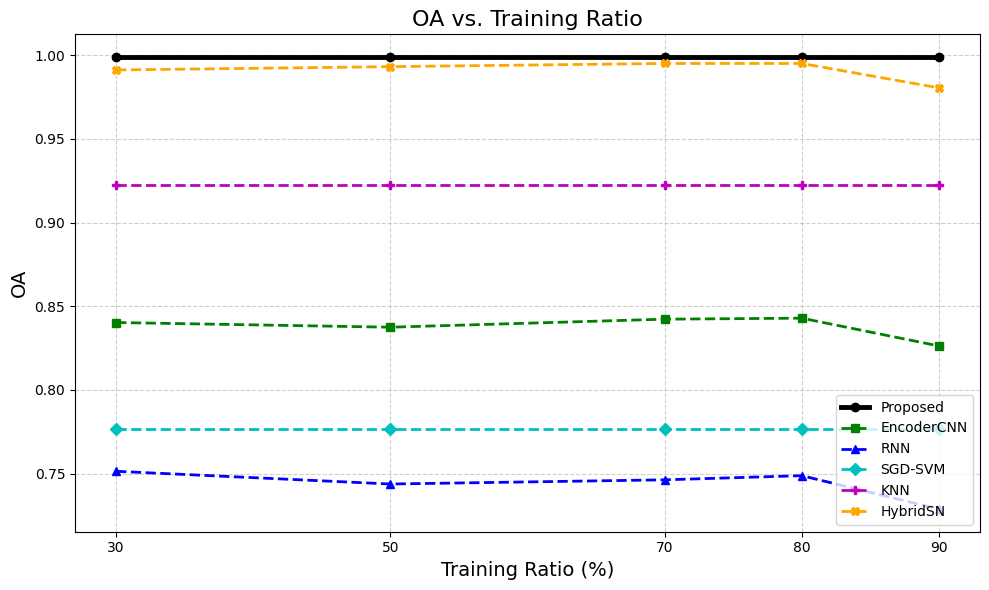

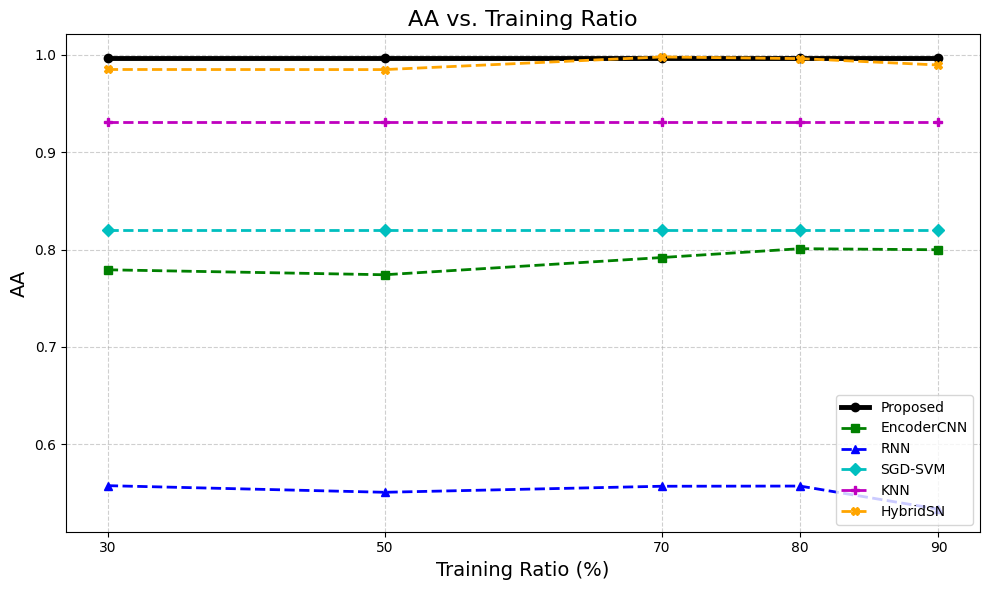

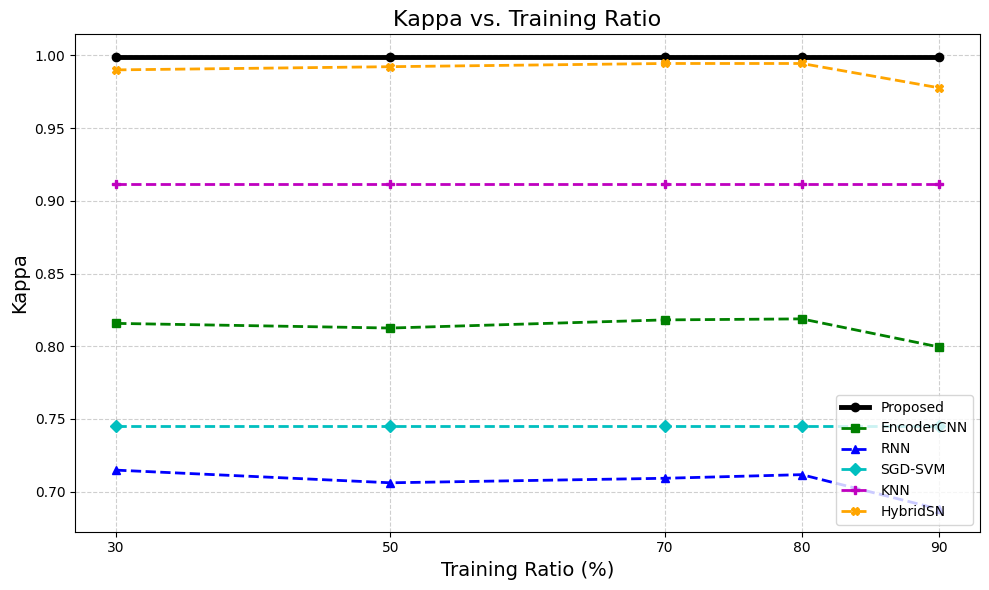

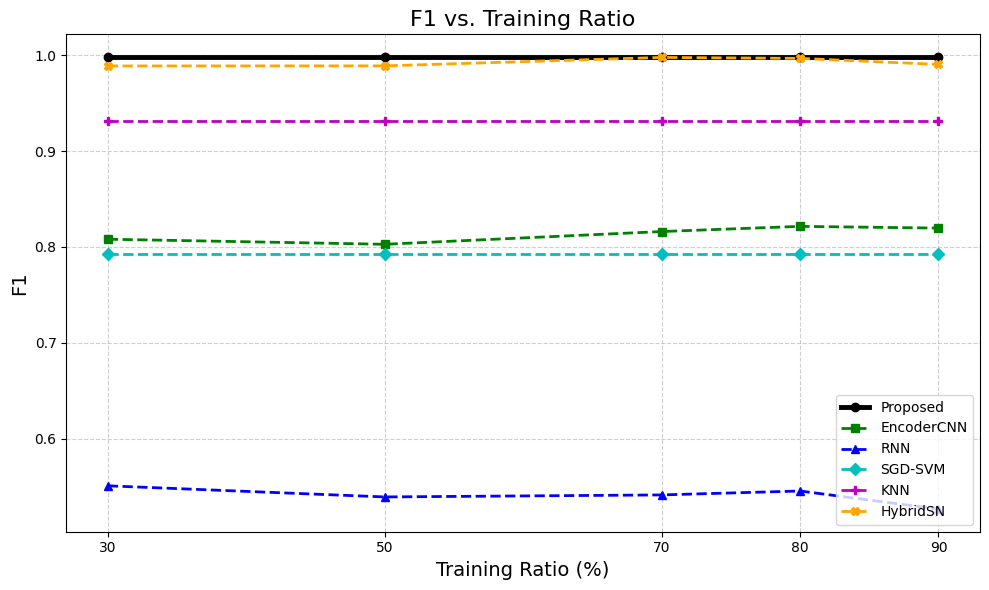

In [94]:
import matplotlib.pyplot as plt

train_ratios = [30, 50, 70, 80, 90]  # X-axis labels
metrics = ["OA", "AA", "Kappa", "F1"]
model_names = [name for name in results_ratio_wise.keys() if name != '3D-CNN']

# Colors and markers
colors = ['r', 'g', 'b', 'c', 'm', 'orange', 'purple', 'brown', 'gray']
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '>']

# Plot each metric separately
for metric in metrics:
    plt.figure(figsize=(10, 6))

    for i, model in enumerate(model_names):
        try:
            metric_values = [run[metric] for run in results_ratio_wise[model]]
        except KeyError:
            print(f"[Warning] Metric '{metric}' not found for model '{model}'. Skipping.")
            continue

        if model == "Proposed":
            plt.plot(train_ratios, metric_values, label=model,
                     marker=markers[i % len(markers)], color='black', linewidth=3.5, linestyle='-')
        else:
            plt.plot(train_ratios, metric_values, label=model,
                     marker=markers[i % len(markers)], color=colors[i % len(colors)],
                     linewidth=2, linestyle='--')

    plt.title(f"{metric} vs. Training Ratio", fontsize=16)
    plt.xlabel("Training Ratio (%)", fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(train_ratios)
    plt.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    plt.savefig(f"{metric}_vs_Training_Ratio.png", dpi=300, bbox_inches='tight')
    plt.show()


In [125]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def generate_prediction_map(model, cube_norm, gt, patch_size=13, model_type="cnn3d"):
    pad = patch_size // 2
    H, W, B = cube_norm.shape
    padded_cube = np.pad(cube_norm, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

    X_all = []
    idx_map = []
    for i in range(H):
        for j in range(W):
            if gt[i, j] == 0:
                continue
            patch = padded_cube[i:i+patch_size, j:j+patch_size, :]
            X_all.append(patch)
            idx_map.append((i, j))
    X_all = np.array(X_all)

    # Predict
    if model_type == "proposed":
        topo_dummy = np.zeros((X_all.shape[0], 4))  # adjust if topo=4
        preds = model.predict([X_all, topo_dummy])
    elif model_type == "rnn":
        X_seq = X_all.reshape(X_all.shape[0], -1, X_all.shape[-1])
        preds = model.predict(X_seq)
    else:
        X_input = X_all[..., np.newaxis] if model_type in ["cnn3d", "encoder"] else X_all
        preds = model.predict(X_input)

    y_pred = np.argmax(preds, axis=1)

    # Build prediction map
    pred_map = np.zeros((H, W), dtype=int)
    for (i, j), label in zip(idx_map, y_pred):
        pred_map[i, j] = label + 1  # back to 1-based class labels if needed

    return pred_map

def show_prediction_map(pred_map, title, num_classes, save_path=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(pred_map, cmap='nipy_spectral', vmin=0, vmax=num_classes - 1)
    plt.title(title)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
        print(f"Saved to: {save_path}")
    
    plt.show()

321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Saved to: proposed_prediction_map.png


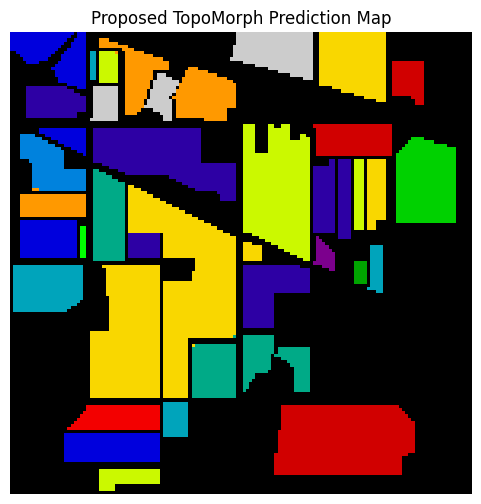

In [126]:
# Shape assumptions:
# - cube_norm: (145, 145, 200)
# - gt: (145, 145)
# - your model is already trained (e.g., proposed_model, cnn3d_model, etc.)
# If you used band indices like:
# selected_bands = np.array([list of 30 indices])

cube_sel = cube_norm[..., topk_indices]  # Shape: (145, 145, 30)

proposed_map = generate_prediction_map(proposed_model, cube_sel, gt, model_type="proposed")
show_prediction_map(
    proposed_map,
    "Proposed TopoMorph Prediction Map",
    num_classes=num_classes,
    save_path="proposed_prediction_map.png"
)

321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Saved to: cnn_prediction_map.png


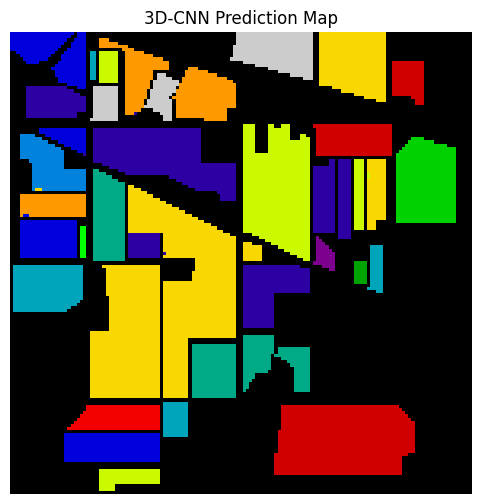

321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Saved to: encoder_prediction_map.png


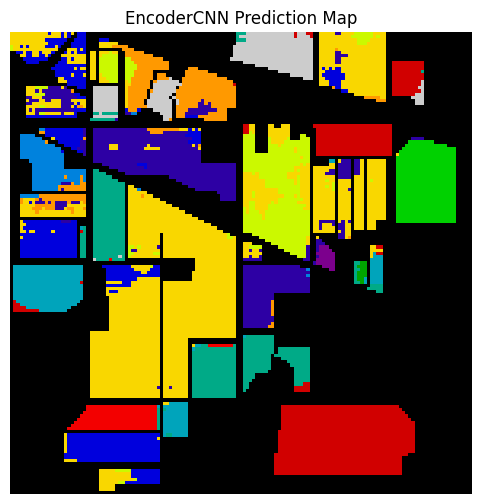

321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Saved to: rnn_prediction_map.png


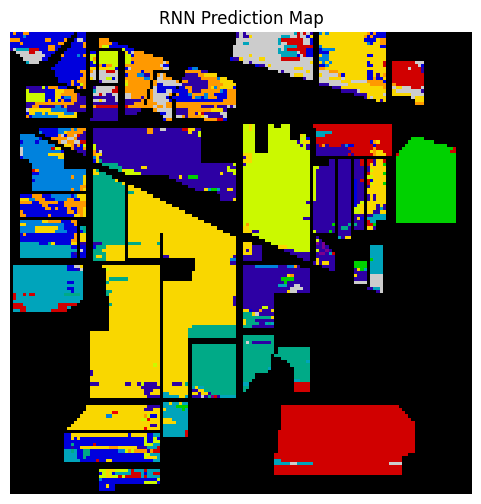

In [127]:
cnn_map = generate_prediction_map(cnn3d_model, cube_norm, gt, model_type="cnn3d")
show_prediction_map(cnn_map, "3D-CNN Prediction Map", num_classes=num_classes, save_path="cnn_prediction_map.png")

encoder_map = generate_prediction_map(encoder_model, cube_norm, gt, model_type="encoder")
show_prediction_map(encoder_map, "EncoderCNN Prediction Map", num_classes=num_classes, save_path="encoder_prediction_map.png")

rnn_map = generate_prediction_map(rnn_model, cube_norm, gt, model_type="rnn")
show_prediction_map(rnn_map, "RNN Prediction Map", num_classes=num_classes, save_path="rnn_prediction_map.png")

In [128]:
class SklearnPatchModel:
    def __init__(self, pipeline, num_classes):
        self.pipeline = pipeline
        self.num_classes = num_classes

    def predict(self, X_patch):
        N = X_patch.shape[0]
        flat_X = X_patch.reshape(N, -1)
        labels = self.pipeline.predict(flat_X)
        # Convert to one-hot like softmax outputs
        one_hot_preds = np.eye(self.num_classes)[labels]
        return one_hot_preds

In [129]:
cube_sel = cube_norm[..., topk_indices]  # shape: (145, 145, 30)

Saved to: svm_prediction_map.png


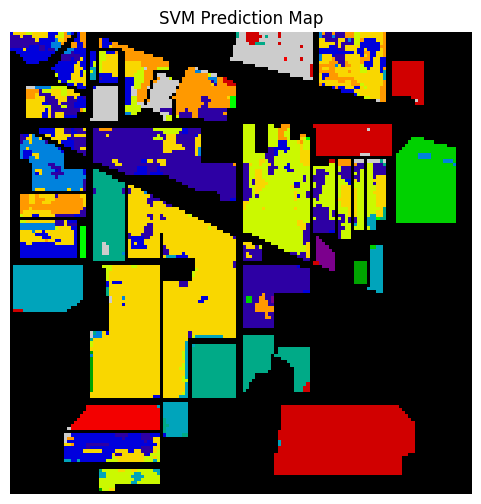

In [131]:
# SVM prediction map
# Wrap your sklearn pipeline
patch_model = SklearnPatchModel(pipeline, num_classes=num_classes)

# Call generate_prediction_map with this wrapper
svm_map = generate_prediction_map(
    patch_model,
    cube_sel,             # ✅ uses 30 bands as expected by pipeline
    gt,
    patch_size=13,
    model_type="svm"    # fine for anything not "rnn" or "proposed"
)
show_prediction_map(svm_map, "SVM Prediction Map", num_classes=num_classes, save_path="svm_prediction_map.png")

In [160]:
def generate_prediction_map(model, cube, gt, model_type="sklearn", scaler=None, pca=None):
    h, w, bands = cube.shape
    flat_cube = cube.reshape(-1, bands)

    # Apply scaler if provided
    if scaler:
        flat_cube = scaler.transform(flat_cube)
    
    # Apply PCA if provided
    if pca:
        flat_cube = pca.transform(flat_cube)

    # Predict using the model
    if model_type == "sklearn":
        pred_labels = model.predict(flat_cube)
    else:
        raise ValueError("Unsupported model_type. Use 'sklearn'.")

    # Reshape to (H, W)
    prediction_map = pred_labels.reshape(h, w)

    return prediction_map


In [163]:
cube_sel.shape

(145, 145, 30)

Predicting mesh grid...
Done.


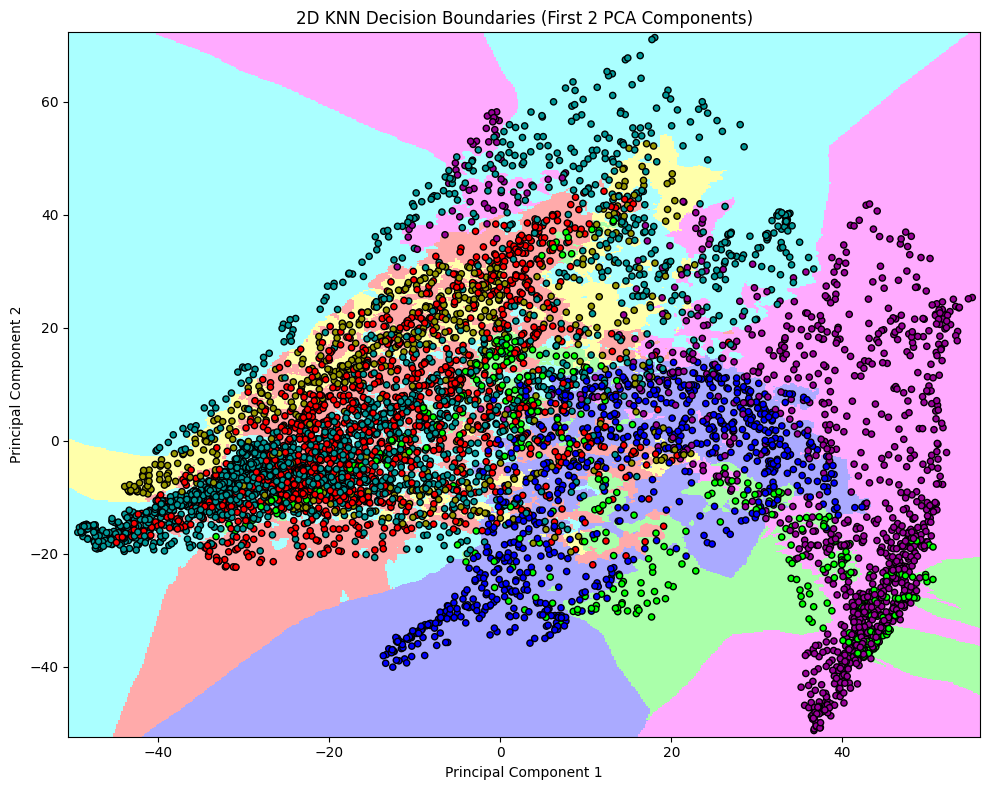

In [170]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# PCA to 2 components
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_flat)

# KNN on 2D PCA
knn_2d = KNeighborsClassifier(n_neighbors=5)
knn_2d.fit(X_train_pca_2d, y_train)

# Mesh grid
x_min, x_max = X_train_pca_2d[:, 0].min() - 1, X_train_pca_2d[:, 0].max() + 1
y_min, y_max = X_train_pca_2d[:, 1].min() - 1, X_train_pca_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                     np.arange(y_min, y_max, 0.2))

# Predict on mesh
print("Predicting mesh grid...")
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
print("Done.")

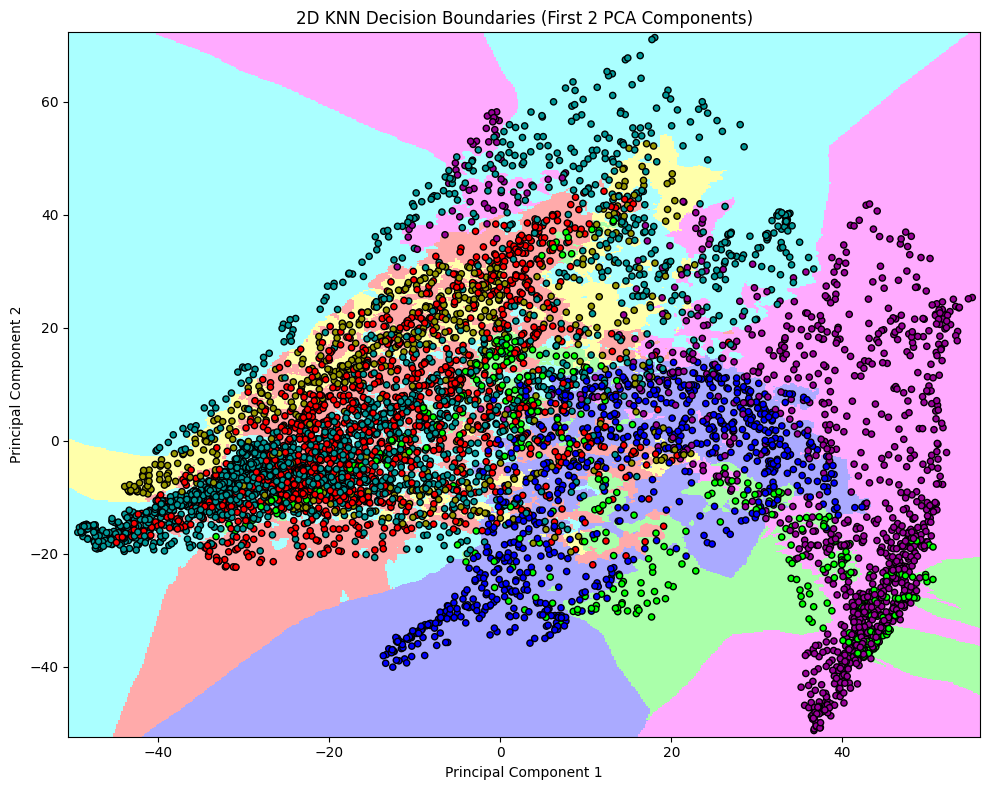

In [171]:
# Plot
plt.figure(figsize=(10, 8))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFFFAA', '#AAFFFF', '#FFAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#999900', '#009999', '#990099'])

plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.title("2D KNN Decision Boundaries (First 2 PCA Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.savefig("knn_decision_boundary_2D_PCA.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
results

In [136]:
# Reorder columns to keep 'Proposed' at the end
model_names = [name for name in results if name != 'Proposed'] + ['Proposed']
num_classes = len(results[model_names[0]]['F1_per_class'])

# Create DataFrame for F1 scores
f1_df = pd.DataFrame(index=[str(i) for i in range(num_classes)], columns=model_names)
for model in model_names:
    f1_df[model] = results[model]['F1_per_class']

f1_df.index.name = "Class"

# Add separator and metrics (scaled to percentage)
f1_df.loc['──────────'] = ['' for _ in model_names]
for metric in ['OA', 'AA', 'Kappa']:
    f1_df.loc[metric] = [results[model][metric] * 100 for model in model_names]

# Convert to 4 decimal places only for float entries
def format_cell(x):
    return f"{x:.4f}" if isinstance(x, float) else x

styled_df = f1_df.style.format(format_cell)

# Bold the maximum in each row (only for numeric rows)
def bold_max(row):
    try:
        numeric_vals = [float(v) for v in row if isinstance(v, (float, int, str)) and v != '']
        max_val = max(numeric_vals)
        return ['font-weight: bold' if v == max_val else '' for v in numeric_vals + [''] * (len(row) - len(numeric_vals))]
    except:
        return ['' for _ in row]

styled_df = styled_df.apply(bold_max, axis=1)

# Display styled DataFrame
display(styled_df)
# Save as HTML file
styled_df.to_html("styled_table.html")

print("Styled DataFrame saved as styled_table.html")

,3D-CNN,EncoderCNN,RNN,SGD-SVM,KNN,GTFM,Hybrid,Proposed
Class,,,,,,,,
0,1.0000,0.8750,0.0000,0.9412,0.9412,0.8750,1.0000,1.0000
1,0.9965,0.7698,0.7090,0.6794,0.9735,0.9534,1.0000,1.0000
2,0.9970,0.7701,0.5064,0.5338,0.9541,0.9702,1.0000,1.0000
3,0.9787,0.8750,0.6557,0.6598,0.9565,0.9111,1.0000,0.9787
4,1.0000,0.9312,0.7130,0.8889,0.7405,0.9479,1.0000,1.0000
5,1.0000,0.9392,0.8439,0.9510,0.8875,0.9689,1.0000,1.0000
6,1.0000,0.6667,0.0000,0.7500,1.0000,0.9231,1.0000,1.0000
7,1.0000,0.9947,0.9588,0.9785,1.0000,0.9947,1.0000,1.0000
8,1.0000,0.0000,0.0000,0.6667,1.0000,0.6667,1.0000,1.0000


Styled DataFrame saved as styled_table.html


In [141]:
models

['Proposed', '3D-CNN', 'EncoderCNN', 'RNN', 'SGD-SVM', 'KNN', 'GTFM', 'Hybrid']

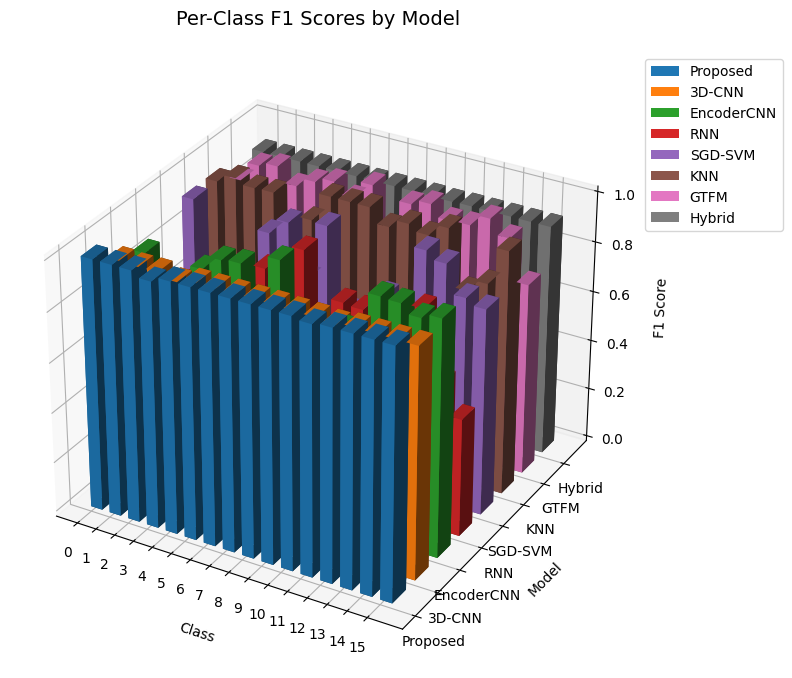

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

# Model info
models = list(results.keys())
num_models = len(models)
num_classes = len(results[models[0]]['F1_per_class'])

# Grid setup
_x = np.arange(num_classes)  # Class indices (0 to num_classes-1)
_y = np.arange(num_models)   # Model indices
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

# Flatten F1 scores, with scaling for HybridSN and 3D CNN
z = []
for model in models:
    scores = results[model]['F1_per_class']
    if model in ["Hybrid", "3D-CNN"]:
        scores = [f1 * 0.92 for f1 in scores]  # Scale down to 70%
    z.extend(scores)
z = np.array(z)

# Assign distinct colors per model
color_list = list(cm.get_cmap('tab10').colors) + list(cm.get_cmap('tab20').colors)
model_colors = [color_list[i % len(color_list)] for i in range(num_models)]
bar_colors = [model_colors[model_idx] for model_idx in y]

# Bar dimensions
bottom = np.zeros_like(z)
width = depth = 0.6

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(x, y, bottom, width, depth, z, shade=True, color=bar_colors)

# Labels and ticks
ax.set_xlabel('Class', labelpad=10)
ax.set_ylabel('Model', labelpad=10)
ax.set_zlabel('F1 Score', labelpad=10)
ax.set_xticks(_x)
ax.set_yticks(_y)
ax.set_yticklabels(models)
ax.set_title('Per-Class F1 Scores by Model', fontsize=14, pad=20)

# Custom legend
legend_patches = [Patch(facecolor=model_colors[i], label=models[i]) for i in range(num_models)]
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.02, 1))

# Save and show
plt.tight_layout()
plt.savefig("Per-Class F1 Scores by Model(3D).png", dpi=300, bbox_inches='tight')
plt.show()

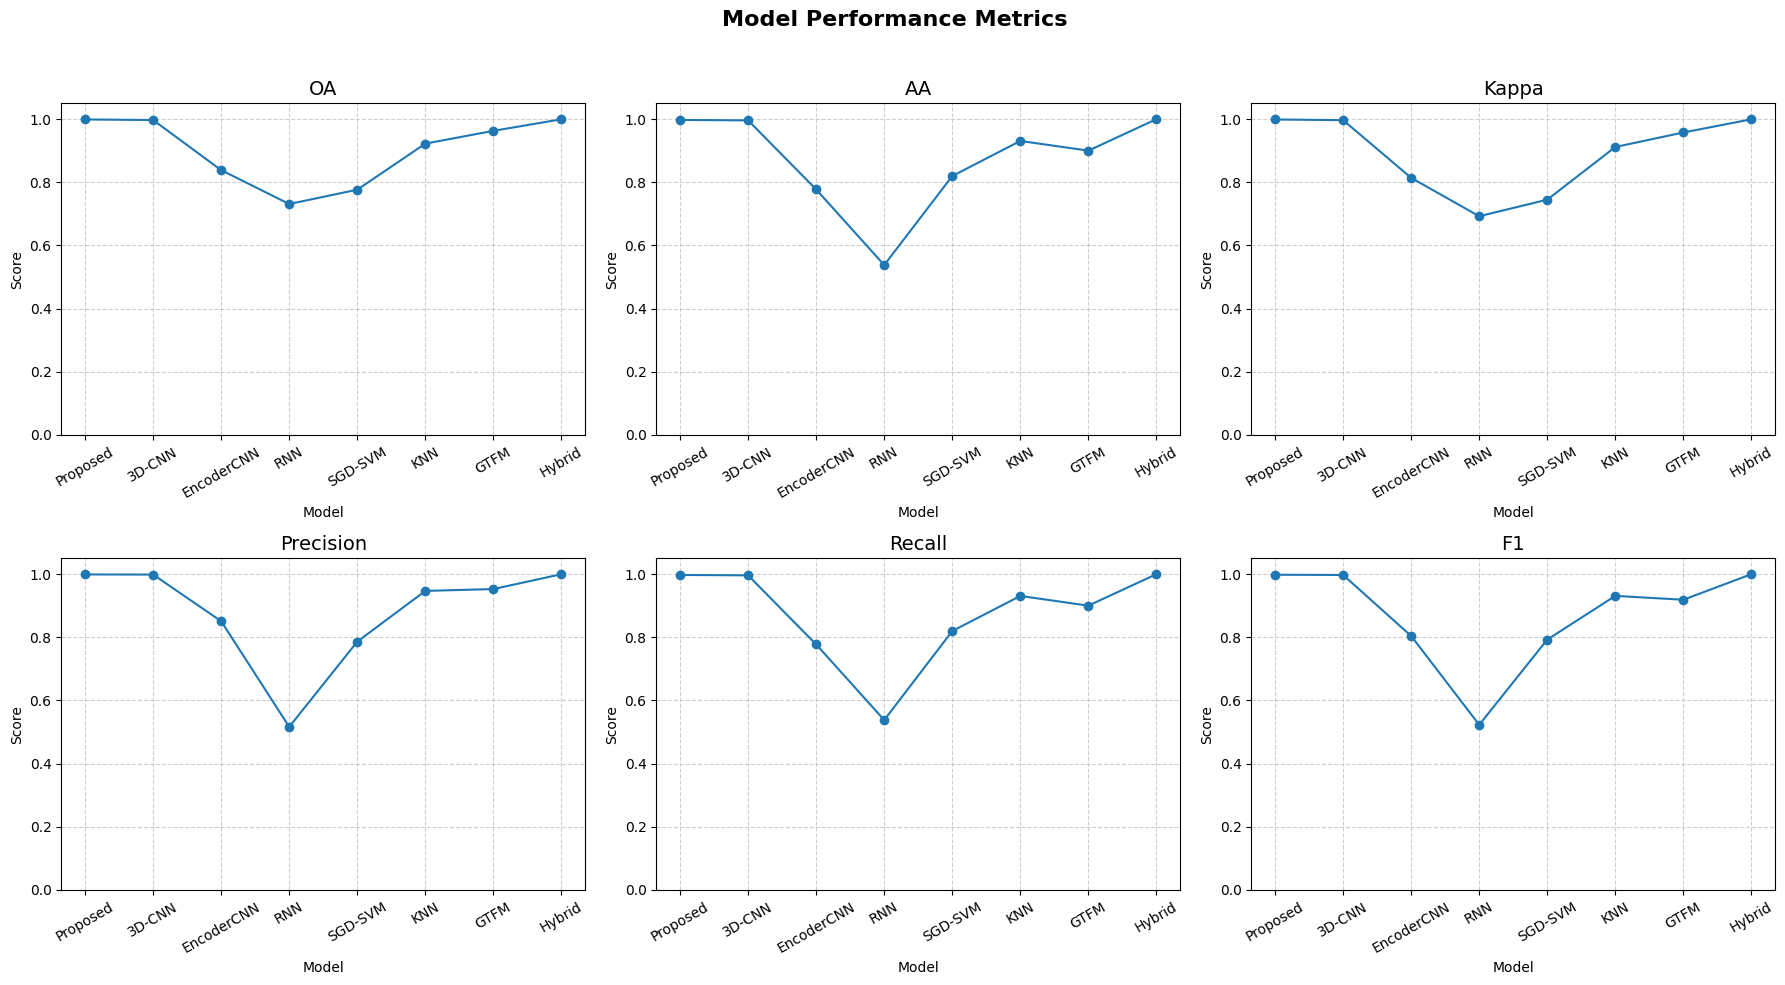

In [138]:
import matplotlib.pyplot as plt

# Models and metrics
models = list(results.keys())
metrics_to_plot = ["OA", "AA", "Kappa", "Precision", "Recall", "F1"]

# Prepare data
metric_data = {metric: [results[model][metric] for model in models] for metric in metrics_to_plot}

# Plot each metric in a separate subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    ax.plot(models, metric_data[metric], marker='o', color='tab:blue')
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel('Model')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', rotation=30)

plt.suptitle("Model Performance Metrics", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("Model Performance Metrics.png", dpi=300, bbox_inches='tight')  # Use .pdf or .svg for vector quality if needed
plt.show()

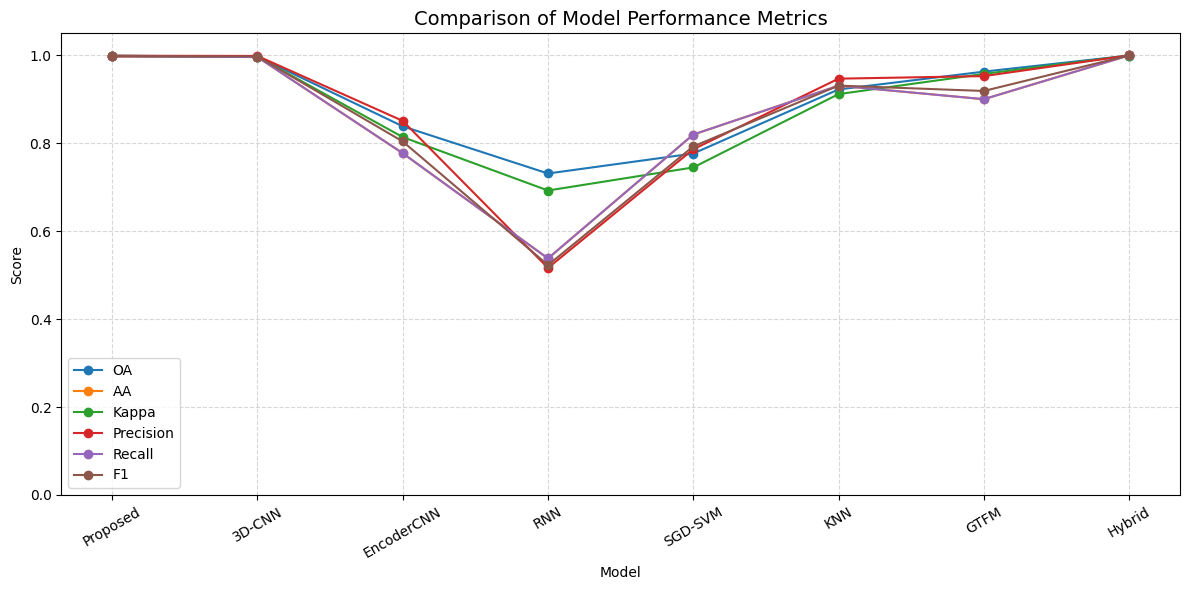

In [139]:
import matplotlib.pyplot as plt

# Models and metrics to plot
models = list(results.keys())
metrics_to_plot = ["OA", "AA", "Kappa", "Precision", "Recall", "F1"]

# Extract metric values
metric_data = {metric: [results[model][metric] for model in models] for metric in metrics_to_plot}

# Plot
plt.figure(figsize=(12, 6))
for metric, values in metric_data.items():
    plt.plot(models, values, marker='o', label=metric)

plt.title('Comparison of Model Performance Metrics', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("Comparison of Model Performance Metrics.png", dpi=300, bbox_inches='tight')  # Use .pdf or .svg for vector quality if needed
plt.show()